In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install xgboost pymc arviz openpyxl
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost
import pytensor
print(pytensor.config.cxx)


/usr/bin/g++


# Predictive Modelling - Traditional ML methods

This section explores how traditional predictive modelling techniques can help identify and quantify computing skills gaps among young Africans. use regression-based models to:

- Predict whether a participant has a computing skills gap (binary classification) given different parameters.
- Estimate a continuous skill score that reflects the computing skills score.

This supports CSA Africa's goals to (1) **evidence the existence of a skill gap**, and (2) **identify the key factors driving it**, enabling more targeted interventions.


## Step 1: Define Target Variables

I will define two types of target variables:
1. A **binary skill gap indicator** (1 = has a skill gap, 0 = no gap), derived from low competence and low programming engagement.
2. A **continuous skill score**, calculated as a composite index based on:
   - Self-rated programming competence
   - Frequency of programming engagement
   - Prior exposure to programming training
   - Training quality
   - Confidence in programming

This dual target setup allows us to run both classification and regression models.


In [4]:
# Step 1: Import pandas
import pandas as pd

# Step 2: Load the Excel file

df = pd.read_excel('/content/drive/MyDrive/data/CSA Africa Market Research Questionnaire.xlsx')


# Step 3: Copy the dataset for modelling
df_model = df.copy()

# View unique values for relevant columns to construct skill score
print("Competence:", df_model['How would you describe your programming competence?'].unique())
print("Engagement:", df_model['How often do you engage in computer programming activities?'].unique())
print("Training:", df_model['Have you ever received training in computer programming?'].unique())
print("Training Quality:", df_model['If you have received computer programming education or training, how would you rate the quality of the training received?'].unique())
print("Confidence:", df_model['I am confident in my problem-solving abilities related to computer programming'].unique())



Competence: ['Novice:\xa0has a better understanding of programming principles and can write code with more confidence compared to beginners; they\xa0may still require some assistance and guidance but are more capable of independently tackling coding tasks.'
 'Beginner:\xa0at the very early stages of learning programming, with limited knowledge and experience, able to write simple code but requiring significant guidance.'
 'Not applicable: has no programming experience'
 'Proficient:\xa0demonstrates a high level of programming knowledge and skill, has extensive experience, and the ability to tackle complex programming challenges with high proficiency and independence.\xa0They are skilled at optimizing code performance and they are trusted to make critical decisions and design robust solutions.'
 'Advanced: possesses an in-depth understanding of advanced programming concepts; proficient in multiple programming languages and frameworks; and has a track record of successfully delivering co

### Step 1:1 Encode Self-Rated Competence (Ordinal)
Map textual descriptions of programming competence to ordinal scores.


In [5]:
# Define mapping from textual levels to numeric scale
competence_map = {
    'Not applicable: has no programming experience': 0,
    'Beginner:\xa0at the very early stages of learning programming, with limited knowledge and experience, able to write simple code but requiring significant guidance.': 1,
    'Novice:\xa0has a better understanding of programming principles and can write code with more confidence compared to beginners; they\xa0may still require some assistance and guidance but are more capable of independently tackling coding tasks.': 2,
    'Intermediate: has a solid understanding of programming principles; with moderate experience and skills to work on substantial projects; they may still require occasional guidance or assistance with more advanced topics.': 3,
    'Advanced: possesses an in-depth understanding of advanced programming concepts; proficient in multiple programming languages and frameworks; and has a track record of successfully delivering complex projects.': 4,
    'Proficient:\xa0demonstrates a high level of programming knowledge and skill, has extensive experience, and the ability to tackle complex programming challenges with high proficiency and independence.\xa0They are skilled at optimizing code performance and they are trusted to make critical decisions and design robust solutions.': 5,
    'Expert: displays exceptional expertise in programming and related domains; considered a subject matter expert in specific programming areas; and has extensive experience and contributions to the programming community.': 6
}

# Apply mapping
df_model['competence_score'] = df_model['How would you describe your programming competence?'].map(competence_map)
df_model['competence_score'].value_counts(dropna=False)


competence_score
0    991
1    737
2    376
3    284
5     87
4     32
6     14
Name: count, dtype: int64

### Assessing Programming Competence: Intepretation (evidences the skill-gap)

To begin quantifying the programming skills gap, I analyzed responses to the self-reported programming competence question. Converted the textual responses into an ordinal scale ranging from 0 (No experience) to 6 (Expert).

The distribution of competence scores reveals a strong skew toward the lower end of the spectrum:

- A significant portion of respondents (over 80%) fall into the "No experience" or "Beginner" categories.
- Only a very small fraction (<5%) report being advanced, proficient, or expert.

This strongly evidences the existence of a widespread computing skills gap in the population targeted by CSA Africa. It aligns with the organization’s hypothesis that many young Africans face barriers to acquiring core programming abilities.


### Step 1:2 Encoding Programming Engagement

To further characterize the skill gap, I analyze the frequency with which respondents engage in programming activities. Frequent engagement often correlates with higher skill development and sustained interest.

The engagement responses are categorical and ordinal in nature, ranging from "Rarely or never" to "Daily". I'll encode these responses into a numeric scale to reflect increasing levels of engagement.

**Encoding scheme:**
- "Rarely or never" → 0
- "Occasionally" → 1
- "Once a week" → 2
- "Several times a week" → 3
- "Daily" → 4


In [6]:
# Encoding engagement frequency
engagement_map = {
    'Rarely or never': 0,
    'Occasionally': 1,
    'Once a week': 2,
    'Several times a week': 3,
    'Daily': 4
}

df_model['engagement_score'] = df_model['How often do you engage in computer programming activities?'].map(engagement_map)

# Display distribution
df_model['engagement_score'].value_counts().sort_index()


engagement_score
0    1015
1     525
2     258
3     423
4     300
Name: count, dtype: int64

### Programming Engagement Score Intepretation

Over 40% of respondents (1,015) rarely or never engage in programming, while only 12% (300) report daily engagement. This disparity highlights limited hands-on experience across the majority—an important indicator of the computing skills gap.


### Step 1:3 - Training Exposure Encoding

To capture a participant's training exposure level, process the column:
**"Have you ever received training in computer programming?"**

This column contains combinations of training types (e.g., bootcamps, self-study, formal courses), concatenated with semicolons.

To quantify learners' exposure to programming training, I assign a score based on how many distinct types of training they report. Each unique "Yes" option adds +1 to their score. If the response contains "No" (indicating no prior exposure), I override all "Yes" entries and assign a score of 0.
.


For instance:
- No training = 0
- One training type = 1
- Two types = 2
- ... and so on

This approach allows to quantify training exposure intensity as an ordinal score.


In [7]:
# List of valid training options (excluding 'No')
yes_options = [
    "Yes, I have engaged in self-study or online programming tutorials",
    "Yes, I have taken formal computer programming courses (e.g., as part of my University degree)",
    "Yes, I have participated in coding workshops or boot camps (Free or Scholarship)",
    "Yes, I have participated in coding workshops or boot camps (Paid)",
    "Yes, I have done programming as part of my academic studies (e.g., assignments, projects)",
    "Yes, I have worked on personal programming projects"
]

no_option = "No, I have not had any previous exposure to computer programming"

def compute_training_score_fixed(response):
    if pd.isnull(response):
        return np.nan
    parts = [x.strip() for x in response.split(";") if x.strip()]

    # Check for "No" — if present, score is 0
    if any(no_option in part for part in parts):
        return 0

    # Count how many valid "Yes" options are matched
    return sum(1 for opt in yes_options if any(opt in part for part in parts))

# Apply
df_model['training_score'] = df_model['Have you ever received training in computer programming?'].apply(compute_training_score_fixed)

# Check distribution
df_model['training_score'].value_counts().sort_index()


training_score
0    1006
1     811
2     316
3     180
4      99
5      60
6      49
Name: count, dtype: int64

#### Step 1:4 - Encoding Training Quality

I now process the training quality scores provided by respondents who had programming training. This variable is already on an ordinal scale (from 0 to 10), where higher values represent better quality training.

Since the responses are numerical, I retain the scale as-is and treat missing values (from respondents with no training) as `NaN` for now. These will be handled during modeling, or optionally imputed later if needed.



In [8]:
# Check the distribution first
df_model['If you have received computer programming education or training, how would you rate the quality of the training received?'].value_counts(dropna=False)


If you have received computer programming education or training, how would you rate the quality of the training received?
NaN     662
0.0     315
5.0     288
8.0     223
7.0     198
4.0     190
6.0     168
3.0     141
10.0    137
9.0      85
2.0      72
1.0      42
Name: count, dtype: int64

In [9]:
# Rename column for ease of access
df_model.rename(columns={
    'If you have received computer programming education or training, how would you rate the quality of the training received?': 'training_quality_score'
}, inplace=True)

# Check counts after renaming
df_model['training_quality_score'].value_counts(dropna=False).sort_index()


training_quality_score
0.0     315
1.0      42
2.0      72
3.0     141
4.0     190
5.0     288
6.0     168
7.0     198
8.0     223
9.0      85
10.0    137
NaN     662
Name: count, dtype: int64

### Training Quality Intepretation

I processed the self-reported quality of programming training received and renamed the column for clarity. The scores range from 0 (poor quality) to 10 (excellent quality). The distribution shows a broad spread of responses, with:

- **315 respondents** rating their training quality as 0,  
- **137 respondents** giving the highest score of 10,  
- and **662 missing values**, which likely correspond to individuals who did not receive any programming training.

This feature provides a useful measure of the **perceived effectiveness** of prior training. I will include it in the composite skill score as an indicator of **training quality**, contributing to a more nuanced understanding of learners’ programming proficiency.


### Step 1:5 Encoding Confidence in Problem-Solving Abilities

I extract a numeric score from participants' self-reported confidence in their problem-solving abilities related to programming. This variable is ordinal, ranging from *"Strongly Disagree"* to *"Strongly Agree"*. To enable modelling, I convert these responses into a scale from 0 to 5, where higher scores reflect greater confidence. For modelling purposes, I assign scores as follows:

- **Strongly Disagree** → 1  
- **Disagree** → 2  
- **Neutral** → 3  
- **Agree** → 4  
- **Strongly Agree** → 5  
- **Not Applicable** → 0 (interpreted as low confidence or unengaged)

This approach maintains consistency with other ordinal encodings and ensures "Not Applicable" does not get dropped from analysis.

In [10]:
import numpy as np

# View unique values for confidence
print(df_model['I am confident in my problem-solving abilities related to computer programming'].unique())

# Map responses to ordinal scale (0 for Not Applicable)
confidence_mapping = {
    "Not Applicable": 0,
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly Agree": 5
}

# Apply mapping
df_model["confidence_score"] = df_model[
    "I am confident in my problem-solving abilities related to computer programming"
].map(confidence_mapping)

# Check value counts
print(df_model["confidence_score"].value_counts())



['Strongly Agree' 'Neutral' 'Agree' 'Not Applicable' 'Strongly Disagree'
 'Disagree']
confidence_score
4    556
3    521
5    504
0    390
2    372
1    178
Name: count, dtype: int64


### Step 1.6: Visualizing the Programming Skills Gap

To support the claim of a widespread programming skills gap among CSA Africa learners, I visualize the distribution of responses across the five components that form the composite skill score:

- **Self-rated programming competence**
- **Frequency of programming engagement**
- **Exposure to programming training**
- **Quality of training received**
- **Confidence in problem-solving abilities**

These variables are encoded on ordinal scales, where higher values indicate stronger proficiency, engagement, or support.

The following histograms and KDE curves show the **distribution of scores for each feature**. If most learners fall on the lower end of the scales, this provides clear evidence of a **skills gap** in the learning population.

By visualizing all five dimensions, I can more holistically assess the extent of this gap across competence, experience, access, and self-belief.



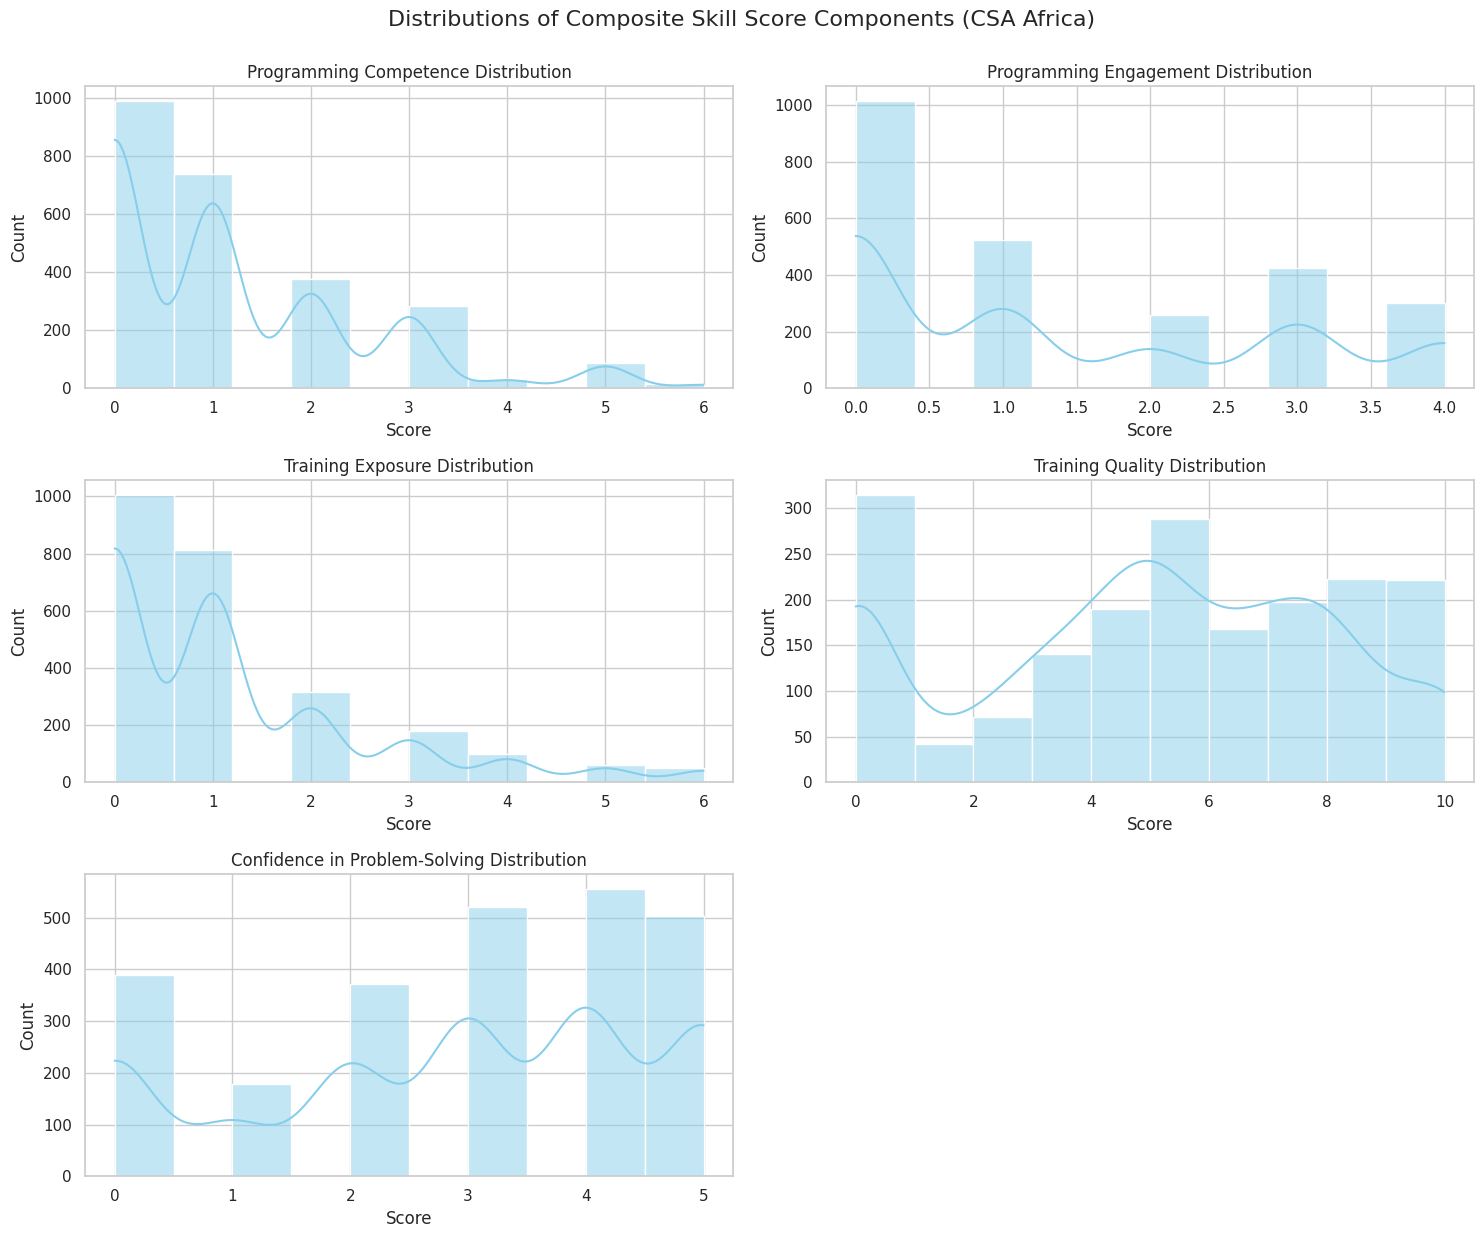

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
axs = axs.flatten()

# Plot settings
features = [
    'competence_score', 'engagement_score',
    'training_score', 'training_quality_score',
    'confidence_score'
]

titles = [
    "Programming Competence", "Programming Engagement",
    "Training Exposure", "Training Quality",
    "Confidence in Problem-Solving"
]

# Histograms
for i, feature in enumerate(features):
    sns.histplot(data=df_model, x=feature, kde=True, bins=10, ax=axs[i], color="skyblue")
    axs[i].set_title(f"{titles[i]} Distribution")
    axs[i].set_xlabel("Score")
    axs[i].set_ylabel("Count")

# Remove unused subplot if 6 plots
for j in range(len(features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Distributions of Composite Skill Score Components (CSA Africa)", fontsize=16, y=1.03)
plt.show()


### Step 1.7 Visualizing Skill Gaps Across Demographic Groups Using Radar Plots

To explore how programming skill development varies across different learner demographics, I use radar plots to compare the five components of the composite skill score:

- **Programming Competence**
- **Programming Engagement**
- **Training Exposure**
- **Training Quality**
- **Confidence in Problem-Solving**

These dimensions are averaged across the following groups:

- **Gender**
- **Age Group**
- **Country of Residence**
- **Educational Qualification**

Radar plots provide a compact and intuitive way to visualize multivariate comparisons. By examining the shapes and areas of the polygons, we can identify which groups tend to score lower or higher across various skill dimensions.

This analysis helps illuminate which subgroups face the largest skill gaps, informing targeted interventions for future programming education initiatives across the CSA Africa community.


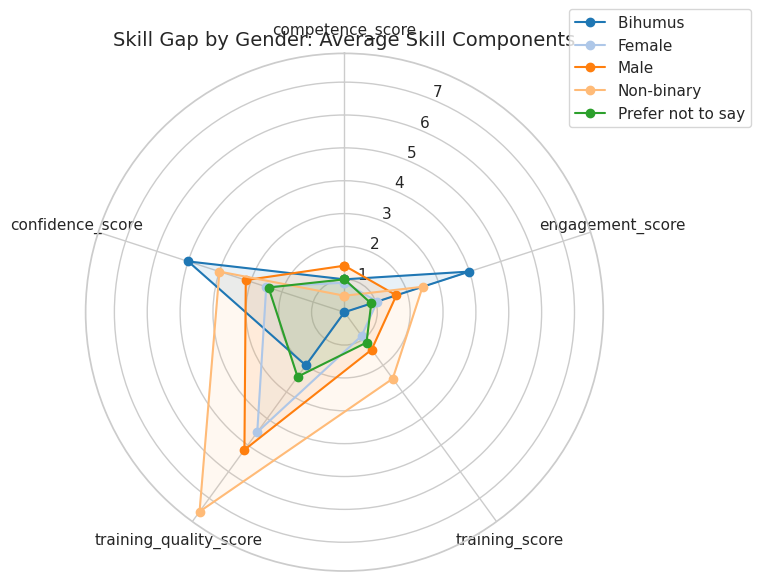

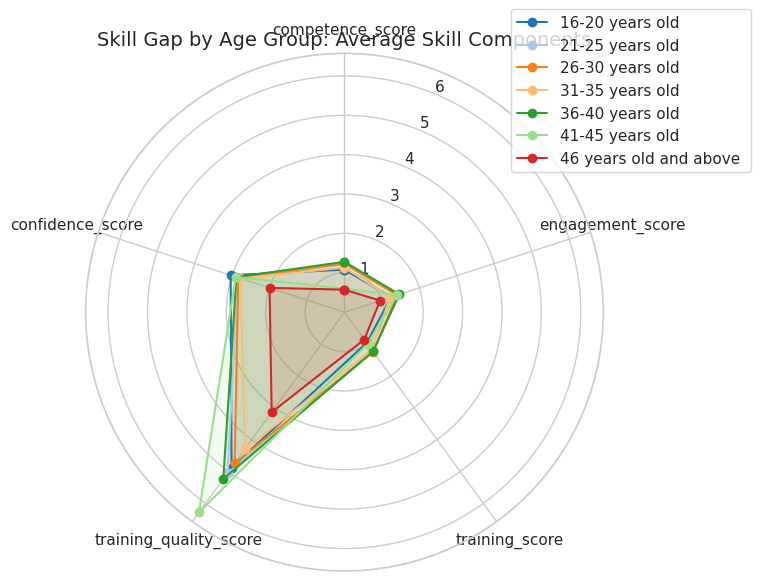

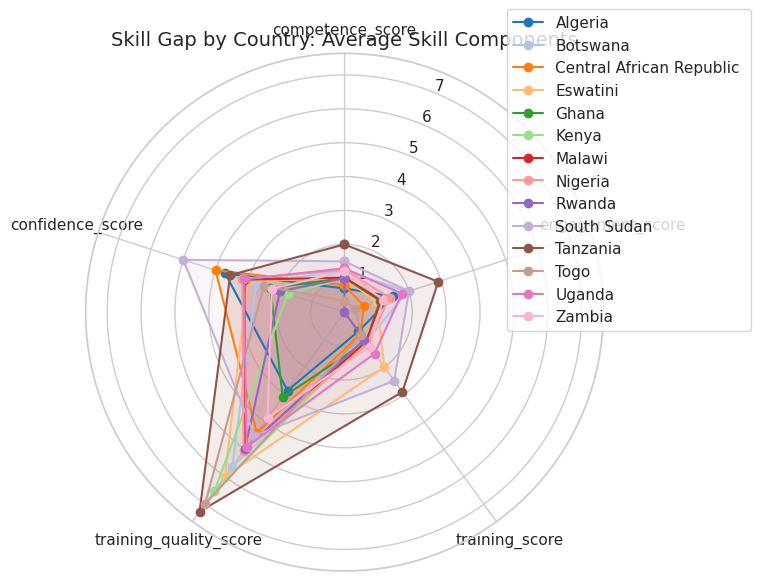

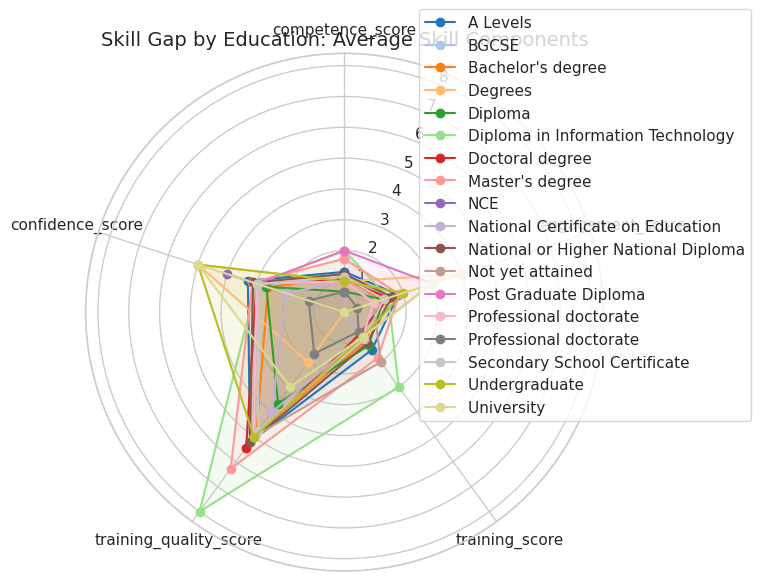

In [12]:
# Define skill score features
skill_features = [
    'competence_score', 'engagement_score', 'training_score',
    'training_quality_score', 'confidence_score'
]

# Define a radar plot function
def plot_radar(df, group_col, title):
    categories = skill_features
    N = len(categories)

    # Compute group means
    grouped = df.groupby(group_col)[categories].mean()

    # Angle settings
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # repeat the first angle to close the plot

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Use distinct seaborn palette
    colors = sns.color_palette("tab20", n_colors=len(grouped))

    for i, group in enumerate(grouped.index):
        values = grouped.loc[group].tolist()
        values += values[:1]
        ax.plot(angles, values, label=group, color=colors[i], marker='o')
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Label setup
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_title(f"{title}: Average Skill Components", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Radar plot by Gender
plot_radar(df_model, 'Gender', 'Skill Gap by Gender')

# Radar plot by Age group
plot_radar(df_model, 'Age', 'Skill Gap by Age Group')

# Radar plot by Country
plot_radar(df_model, 'Country of residence', 'Skill Gap by Country')

# Radar plot by Education
plot_radar(df_model, 'Highest educational level (already attained)', 'Skill Gap by Education')


# Skill Gap Radar Plot Interpretations

## Skill Gap by Gender: Average Skill Components

- **Non-binary** participants exhibit the highest averages in most dimensions, particularly in _training quality_, _training exposure_, and _confidence_. Could be because of few samples
- **Female** participants show modest but balanced skill levels, with lower competence and engagement scores.
- **Male** participants show relatively low values across all components, particularly in _confidence_ and _competence_,  but higher than females
- **“Prefer not to say”** and **Bihumus** groups generally show the lowest average values, with Bihumus peaking only in _confidence_ and _engagement_.

> **Insight:** There is a clear skill gap across gender identities. Males and non-binary participants show contrasting trends. Females show moderate scores and lower than the male population, while “prefer not to say” and Bihumus groups may need targeted support.

---

## Skill Gap by Age Group: Average Skill Components

- The **21–25** and **26–30** age groups exhibit stronger average skills across most components, especially in _confidence_ and _training quality_.
- **16–20** and **46+** groups consistently show the lowest scores, indicating a U-shaped pattern in skills.
- The **41–45** group shows a spike in _training quality_, suggesting access to higher quality training but lower engagement or competence.

> **Insight:** Middle-aged groups (especially 21–40) tend to have stronger skill profiles, while younger and older participants are more likely to face skill gaps.

---

## Skill Gap by Country: Average Skill Components

- **Tanzania**, **Togo** and **Kenya** exhibit strong averages across skill dimensions, particularly in _training quality_ and _confidence_.
- **South Sudan**, **Eswatini**,  show relatively high _training_ scores but low _competence_ and _engagement_.
- **Zambia**, **Ghana**, and **Rwanda** are among the lowest performing across features.
- **Algeria** shows average but more balanced profiles.

> **Insight:** There is a clear cross-country disparity in skill acquisition. While countries like Tanzania lead in most areas, others lag behind significantly—suggesting a need for country-specific interventions.

---

## Skill Gap by Education Level: Average Skill Components

- **Diploma**, **University** and **Undergraduate** attained participants score higher across most skill components.
- **Diploma in Information Technology** stands out with the highest _training quality_ and _confidence_ scores.
- **Secondary education levels** such as _A Levels_ and _BGCE_ show weaker scores in _competence_ and _engagement_.
- Participants with **“Not yet attained”** or **NCE** qualifications report the lowest overall scores.

> **Insight:** Higher levels of formal education, especially tertiary and technology-related degrees, correlate with stronger programming skill profiles. Skill gaps are more prevalent among those with lower or incomplete educational attainment.

---


### Step 1:8 Constructing the composite score
To quantify learners' programming proficiency in a single measure, I construct a composite skill score using five variables:

- Programming competence (`competence_score`)
- Programming engagement frequency (`engagement_score`)
- Training breadth (`training_score`)
- Quality of training received (`training_quality_score`)
- Confidence in problem-solving (`confidence_score`)

These components reflect different dimensions of skill acquisition. I calculate the composite score as a simple average of the available (non-null) scores. This ensures that missing values in one area do not completely exclude the respondent from analysis, while still maintaining interpretability.




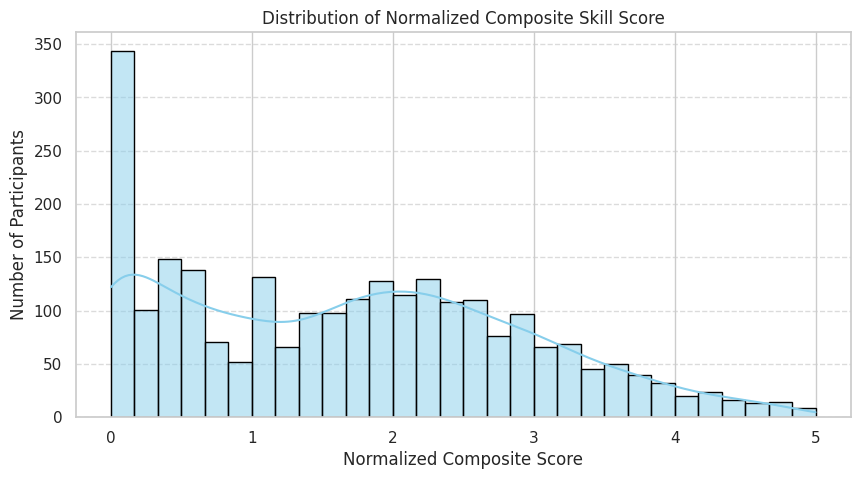

In [13]:
from sklearn.preprocessing import MinMaxScaler


# Columns to normalize
skill_cols = ['competence_score', 'engagement_score', 'training_score', 'training_quality_score', 'confidence_score']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax scaling
df_model[[f'{col}_norm' for col in skill_cols]] = scaler.fit_transform(df_model[skill_cols])

# Calculate the normalized composite skill score
df_model['normalized_composite_skill_score'] = df_model[[f'{col}_norm' for col in skill_cols]].sum(axis=1)

# Plot the normalized distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_model['normalized_composite_skill_score'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Normalized Composite Skill Score')
plt.xlabel('Normalized Composite Score')
plt.ylabel('Number of Participants')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Interpretation of the Normalized Composite Skill Score Distribution

The distribution of the normalized composite skill scores shows a strong left skew, with a substantial number of participants concentrated near the lower end of the scale. This suggests that a large proportion of the sample exhibits low programming proficiency based on their combined competence, engagement, training exposure, training quality, and confidence levels. While there is a gradual decline in frequency as the score increases, relatively few individuals attain high normalized scores close to the upper limit. This further evidences the presence of a significant skills gap among the surveyed population.


### Step 3: Selecting Features for Predictive Modelling

Now that I’ve constructed a normalized composite skill score to represent learners’ programming proficiency, I will select a set of meaningful independent variables (features) that are likely to influence this skill score. These features span across socio-demographic, infrastructural, and psychological/mindset, social-cultural dimensions and are aligned with CSA Africa’s goal of identifying causal factors for the digital skills gap.


In [14]:
# Define the list of predictor variables (features)
predictor_features = [
    'Age',
    'Gender',
    'Country of residence',
    'Do you have childcare responsibilities?',
    'Highest educational level (already attained)',
    'Employment status',
    'Do you have access to a computer or laptop at your home or within your community?',
    'Do you have access to good internet to support your learning of programming?',
    'Can you afford the cost of accessing the internet for approximately 15 - 20hrs weekly?',
    'How much electricity access do you have to learn programming per day?',
    'How would you rate the level of support you receive from your parent/guardian/spouse in learning computer programming?',
    'How would you describe your current perception of learning computer programming?',
    'What is the major factor limiting your engagement?',
    'Programming is primarily for individuals with strong mathematical or technical backgrounds',
    'I am aware of the various career opportunities available for individuals with computer programming skills',
    'It is important for me to see more representation of my cultural or societal background in the programming industry',
    'It is important for me to have access to mentors or role models in the field of computer programming',
    'On a scale of 1 to 10, how interested are you in learning computer programming or improving on your skills?',
    'Would you be more motivated to learn computer programming if there were more coding communities or meetups in your area?',
    'What career paths are you interested in pursuing with your computer programming skills?',
    'Which of the following factors most strongly motivates you to learn computer programming?',
    'Which of the following challenges have you faced in learning or improving your computer programming skills?',
    'I have encountered societal beliefs that discourage my pursuit of computer programming',
    'I have faced gender-related barriers or stereotypes that discourage my involvement in programming',
    'My immediate family is supportive of my decision to pursue programming',
    'I have experienced societal pressure to pursue traditional career paths instead of programming',
    'I have faced significant barriers in finding relevant opportunities to apply my programming skills',
    'Have you found online coding platforms or communities specifically tailored to the needs of young Africans?',
    'Online learning platforms tailored to the needs of young Africans will enhance my learning process',
    'Have you faced any English language barrier in learning programming?'
]

# Display the selected features
print(f"Number of selected features: {len(predictor_features)}")
# for feature in predictor_features:
#     print("-", feature)


Number of selected features: 30


## Feature Encoding and Preprocessing - Massaging the data for modelling

Before fitting any predictive models, I need to prepare the selected predictor features by encoding them into numerical form. Since most of the features are categorical or ordinal in nature, I’ll use the following strategies:

- **Binary & Single-Select Categorical Variables:** Encoded using Label Encoding (e.g., "Yes"/"No", "Male"/"Female").
- **Nominal Categorical Variables (multi-class):** One-Hot Encoding is used for features like "Country of Residence" or "Employment Status".
- **Ordinal Variables:** Preserved with meaningful numerical ordering where applicable.
- **Multi-Select Text Fields:** These will be simplified into binary indicators based on presence of selected options.

After this step, the resulting DataFrame will contain only numeric values, ready for regression modeling.


In [15]:
# from sklearn.preprocessing import LabelEncoder

# # Make a working copy of the dataset
# df_encoded = df_model.copy()

# # Strip leading/trailing spaces from column names in both the dataframe and feature list
# df_encoded.columns = df_encoded.columns.str.strip()
# predictor_features = [f.strip() for f in predictor_features]

# # Container for final features
# final_encoded_df = pd.DataFrame(index=df_encoded.index)

# # Feature encoding loop
# for feature in predictor_features:
#     if feature not in df_encoded.columns:
#         print(f"Skipping {feature} - Not found in dataset.")
#         continue

#     col_data = df_encoded[feature].fillna("Missing")

#     unique_vals = col_data.nunique()

#     if unique_vals == 2:
#         # Binary categorical
#         le = LabelEncoder()
#         final_encoded_df[feature] = le.fit_transform(col_data)
#     elif unique_vals <= 10:
#         # Ordinal / small nominal
#         le = LabelEncoder()
#         final_encoded_df[feature] = le.fit_transform(col_data)
#     elif unique_vals < 100:
#         # Nominal with moderate cardinality
#         dummies = pd.get_dummies(col_data, prefix=feature, drop_first=True)
#         final_encoded_df = pd.concat([final_encoded_df, dummies], axis=1)
#     else:
#         print(f"Skipping {feature} - Too many unique values ({unique_vals})")

# print(f"\nFinal shape of encoded feature set: {final_encoded_df.shape}")


In [16]:
for col in df_model.columns:
    print(col)

ID
Start time
Completion time
Email
Name
Do we have your consent to proceed?
Age
Gender
Which of the following best describes your status?
Do you have childcare responsibilities?
How many child/children do you have?
Country of residence
City of residence
Highest educational level (already attained)
Educational level (ongoing)
Field of study
Employment status
If employed part or full-time, what is your job description?
Arabic
English
French
Hausa
Swahili
Zulu
Do you have access to a computer or laptop at your home or within your community?
Do you have access to good internet to support your learning of programming?
Can you afford the cost of accessing the internet for approximately 15 - 20hrs weekly?
How much electricity access do you have to learn programming per day? 
Have you ever received training in computer programming?
training_quality_score
How would you rate the level of support you receive from your parent/guardian/spouse in learning computer programming?
What source of income

In [17]:
import pickle
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Strip column names of extra whitespace
df_model.columns = df_model.columns.str.strip()

# Step 1: Define the renaming dictionary (old column name → new readable name)
renaming_dict = {
    'Age': 'age',
    'Gender': 'gender',
    'Which of the following best describes your status?': 'participant_status',
    'How many child/children do you have?': 'number_of_children',
    'Country of residence': 'country',
    'Do you have childcare responsibilities?': 'childcare_responsibilities',
    'Highest educational level (already attained)': 'education_level',
    'Educational level (ongoing)': 'education_ongoing',
    'Field of study': 'field_of_study',
    'Employment status': 'employment_status',
    'If employed part or full-time, what is your job description?': 'job_description',
    'Do you have access to a computer or laptop at your home or within your community?': 'access_to_computer',
    'Do you have access to good internet to support your learning of programming?': 'access_to_internet',
    'Can you afford the cost of accessing the internet for approximately 15 - 20hrs weekly?': 'afford_internet_cost',
    'How much electricity access do you have to learn programming per day?': 'electricity_access',
    'How would you rate the level of support you receive from your parent/guardian/spouse in learning computer programming?': 'spouse_parent_support',
    'What source of income have you used to support your previous exposure to programming?': 'income_source',
    'How would you describe your current perception of learning computer programming?': 'current_perception_programming',
    'What is the major factor limiting your engagement?': 'engagement_limiting_factor',
    'Programming is primarily for individuals with strong mathematical or technical backgrounds': 'math_technical_background_belief',
    'I am aware of the various career opportunities available for individuals with computer programming skills': 'career_awareness',
    'It is important for me to see more representation of my cultural or societal background in the programming industry': 'representation_importance',
    'It is important for me to have access to mentors or role models in the field of computer programming': 'mentorship_importance',
    'On a scale of 1 to 10, how interested are you in learning computer programming or improving on your skills?': 'interest_in_programming',
    'Would you be more motivated to learn computer programming if there were more coding communities or meetups in your area?': 'community_meetups_events',
    'What career paths are you interested in pursuing with your computer programming skills?': 'career_paths',
    'Which of the following factors most strongly motivates you to learn computer programming?': 'motivation_factors',
    'Which programming languages are you most interested in learning?': 'interested_coding_languages',
    'What is your motivation for selecting the programming language above?': 'coding_language_motivation',
    'Which of the following challenges have you faced in learning or improving your computer programming skills?': 'learning_challenges',
    'I have encountered societal beliefs that discourage my pursuit of computer programming': 'societal_beliefs_barrier',
    'I have faced gender-related barriers or stereotypes that discourage my involvement in programming': 'gender_barriers',
    'My immediate family is supportive of my decision to pursue programming': 'immediate_family_support',
    'I have experienced societal pressure to pursue traditional career paths instead of programming': 'pressure_for_traditional_careers',
    'I have faced significant barriers in finding relevant opportunities to apply my programming skills': 'barriers_to_opportunities',
    'There are societal expectations  within my community that prioritises other subjects of study over programming': 'community_bias_to_programming',
    'I lack practical guidance or mentorship in applying my programming skills to real-world scenarios': 'lack_practical_guidance',
    'I sometimes feel there are gaps in my skills that hinder the application of my programming abilities': 'self_reported_skill_gaps',
    'I have faced challenges in adapting my programming skills to the specific requirements of different projects': 'adaptation_challenges_of_skills_to_projects',
    'It is important for me to have access to practical projects, internships, or work experiences in enhancing the application of my programming skills': 'importance_of_practical_experience',
    'Suppose you come across a paid internship opportunity in some area of computer programming, would you apply?': 'willingness_to_apply_for_internship',
    'Have you found online coding platforms or communities specifically tailored to the needs of young Africans?': 'african_learning_platforms_available',
    'Online learning platforms tailored to the needs of young Africans will enhance my learning process': 'african_platforms_helpful',
    'Have you faced any English language barrier in learning programming?': 'english_language_barrier',
    'What type of learning resources do you find most helpful for learning computer programming? (Select all that apply)': 'preferred_learning_resources',
    'I will not be able to effectively learn online without internet support': 'internet_dependency_learning',
    'I will not be able to effectively learn online/physically without computer support': 'computer_dependency_learning',
    'I will not be able to effectively learn online/physically without childcare support': 'childcare_dependency_learning',
    'I will not be able to effectively learn online without electricity support': 'electricity_dependency_learning',
    'With your family/study/work responsibilities, how much time can you commit to learning coding per day?': 'daily_learning_time_commitment',
    'With your responsibilities, what type/structure of learning programming would work for you? (select all that apply)': 'preferred_learning_structure',
}


# Step 2: Rename columns
df_model.rename(columns=renaming_dict, inplace=True)

# Step 3: Define the updated predictor features
predictor_features = list(renaming_dict.values())

# Step 4: Initialize storage
encoders_dict = {}
df_encoded = df_model.copy()
final_encoded_df = pd.DataFrame(index=df_encoded.index)

# Step 5: Encoding loop
for feature in predictor_features:
    if feature not in df_encoded.columns:
        print(f"Skipping {feature} - Not found in dataset.")
        continue

    col_data = df_encoded[feature].fillna("Missing")

    if col_data.nunique() == 2:
        le = LabelEncoder()
        final_encoded_df[feature] = le.fit_transform(col_data.astype(str))
        encoders_dict[feature] = le
    elif col_data.nunique() <= 10:
        le = LabelEncoder()
        final_encoded_df[feature] = le.fit_transform(col_data.astype(str))
        encoders_dict[feature] = le
    elif 10 < col_data.nunique() < 100:
        dummies = pd.get_dummies(col_data, prefix=feature, drop_first=True)
        final_encoded_df = pd.concat([final_encoded_df, dummies], axis=1)
    else:
        print(f"Skipping {feature} - Too many unique values ({col_data.nunique()})")

print(f"Final shape of encoded feature set: {final_encoded_df.shape}")

# Step 6: Save encoders and column order
# with open("fitted_label_encoders.pkl", "wb") as f:
#     pickle.dump(encoders_dict, f)

# with open("final_feature_columns.pkl", "wb") as f:
#     pickle.dump(list(final_encoded_df.columns), f)

# print("Encoders and column order saved!")


Skipping field_of_study - Too many unique values (112)
Skipping job_description - Too many unique values (673)
Skipping income_source - Too many unique values (232)
Skipping engagement_limiting_factor - Too many unique values (1126)
Skipping motivation_factors - Too many unique values (151)
Skipping interested_coding_languages - Too many unique values (479)
Skipping coding_language_motivation - Too many unique values (1387)
Skipping learning_challenges - Too many unique values (951)
Skipping community_bias_to_programming - Not found in dataset.
Skipping preferred_learning_resources - Too many unique values (753)
Skipping electricity_dependency_learning - Not found in dataset.
Skipping preferred_learning_structure - Too many unique values (286)
Final shape of encoded feature set: (2521, 212)


In [18]:
# Merge encoded predictors with the normalized composite skill score
final_df = final_encoded_df.copy()
final_df['normalized_composite_skill_score'] = df_model['normalized_composite_skill_score']

# Drop any rows where the skill score is missing (if any)
final_df = final_df.dropna(subset=['normalized_composite_skill_score'])

# Confirm the final dataset shape and preview
print(f"Final modelling dataset shape: {final_df.shape}")
final_df.head()


Final modelling dataset shape: (2521, 213)


age  gender  participant_status  number_of_children  country_Botswana  \
0    1       2                   7                   8             False   
1    4       2                   3                   4             False   
2    3       1                   3                   3             False   
3    4       2                   3                   3             False   
4    4       2                   3                   4             False   

   country_Central African Republic   country_Eswatini  country_Ghana  \
0                              False             False          False   
1                              False             False           True   
2                              False             False           True   
3                              False             False           True   
4                              False             False           True   

   country_Kenya  country_Malawi  ...  importance_of_practical_experience  \
0          False           False  ...                                   0   
1          False           False  ...                                   0   
2          False           False  ...                                   4   
3          False           False  ...                                   4   
4          False           False  ...                                   2   

   willingness_to_apply_for_internship  african_learning_platforms_available  \
0                                    1                                     0   
1                                    2                                     0   
2                                    2                                     0   
3                                    0                                     0   
4                                    0                                     0   

   african_platforms_helpful  english_language_barrier  \
0                          4                         0   
1                          0                         0   
2                          2                         0   
3                          4                         1   
4                          2                         0   

   internet_dependency_learning  computer_dependency_learning  \
0                             2                             2   
1                             4                             0   
2                             4                             4   
3                             0                             4   
4                             2                             2   

   childcare_dependency_learning  daily_learning_time_commitment  \
0                              3                               3   
1                              0                               1   
2                              0                               1   
3                              0                               0   
4                              2                               0   

   normalized_composite_skill_score  
0                          2.000000  
1                          1.783333  
2                          1.783333  
3                          1.000000  
4                          0.000000  

[5 rows x 213 columns]

In [19]:
# final_df.head().to_excel("df_sample.xlsx", index=False)

## Linear Regression: Predicting Programming Skill Score

### Objective
In this section, I apply a **traditional linear regression model** to predict the `normalized_composite_skill_score`, which serves as a proxy for programming proficiency among participants. This score was computed by combining multiple indicators of skill acquisition such as self-rated competence, frequency of coding engagement, training exposure, training quality, and confidence.

The goal is to estimate how various socio-demographic, infrastructural, motivational, and perceptual features influence an individual’s overall programming skill level. This aligns directly with CSA Africa’s objective of identifying and addressing the underlying factors contributing to digital skill disparities.

---

###  Why Linear Regression?
Linear regression is a fundamental predictive modeling technique that estimates the **linear relationship** between input variables (predictors) and a continuous outcome (target). It is especially useful for:

- Measuring how much each feature contributes to the predicted skill score.
- Interpreting feature coefficients to assess their relative influence.
- Establishing a baseline for comparison with more complex models (e.g., Bayesian or causal models later on).

---

### Modelling Workflow

Here’s how I approach the modelling process:

1. **Import necessary libraries**: I load tools for regression, evaluation, and data manipulation.
2. **Define predictors and target**: The independent variables (`X`) consist of all encoded participant features. The dependent variable (`y`) is the normalized skill score.
3. **Split the data**: I use an 80/20 split for training and testing to evaluate model performance on unseen data.
4. **Train the model**: I fit a `LinearRegression` model to the training set.
5. **Evaluate performance**: I compute RMSE (root mean square error) and R² (coefficient of determination) to assess prediction accuracy.
6. **Interpret feature importance**: I analyze the learned coefficients to understand which features most strongly predict higher or lower skill levels.

This linear regression model serves as a transparent and interpretable first step in identifying predictors of programming proficiency in the African context.


In [20]:
# For modelling and evaluation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [21]:
# Features are all columns except the target
X = final_df.drop(columns=['normalized_composite_skill_score'])

# Target is the normalized skill score
y = final_df['normalized_composite_skill_score']


In [22]:
# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [24]:
# Predictions
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 0.8621
R² Score: 0.4950


In [25]:
# Coefficients and feature impact
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

feature_importance.head(213)  # Show top 10 positive predictors


Feature  Coefficient
52                          education_ongoing_Grade 12     3.295878
79                  education_ongoing_Vocational Study     3.246024
58                               education_ongoing_NCE     3.178240
62           education_ongoing_Online course (Cousera)     3.011266
78                education_ongoing_Vocational Studies     2.912292
..                                                 ...          ...
117  current_perception_programming_I haven't learn...    -1.354842
114  current_perception_programming_I have no exper...    -1.372828
184                        career_paths_Product Design    -1.428392
176                      career_paths_Graphics design     -1.689494
115  current_perception_programming_I have no knowl...    -1.914918

[212 rows x 2 columns]

### Linear Regression Model Summary

The linear regression model provided an interpretable baseline for predicting the composite programming skill score based on socio-demographic, infrastructural, and psychological factors.

**Model Performance:**
- **RMSE (Root Mean Squared Error):** ~0.87 — This indicates a moderate average prediction error given the normalized skill score range (0–5).
- **R² Score:** 0.49 — The model explains approximately **49%** of the variance in skill scores. While this shows the model captures some meaningful relationships, it also suggests that over half the variation remains unexplained.

**Top Predictors Identified:**
The features with the strongest positive influence on programming skill scores include:
- Achieving certain levels of **education**.
- **Self-initiated** efforts (e.g., Coursera, ALX, bootcamps) strongly influence outcomes, reinforcing the value of non-traditional pathways.
- Current **psychological perceptions** of programming.
- Residing in **South Sudan**, **Tanzania**, **Malawi**, or **Uganda**.
- Expressing interest in specific **career aspirations** in programming (e.g., backend development).
  

These results provide useful directional insights into which contextual and psychological factors may be linked with higher skills attainment.

**Limitations:**
However, linear models assume simple additive relationships and may not fully capture:
- **Non-linear interactions** (e.g., between infrastructure and mindset),
- **Feature interactions** (e.g., education * electricity access),
- **Complex dependencies** or latent structure in the data.

---

### Next Steps

To improve predictive performance and uncover deeper patterns, I will now explore **non-linear machine learning models**, such as:
- **Random Forest Regressor**
- **Gradient Boosting Regressor**

These models are better suited to handle complex, high-dimensional data and can often achieve higher accuracy without requiring extensive feature engineering.


### Random Forest Regressor

I now train a Random Forest regression model to improve upon the linear regression baseline. Random Forest is a powerful ensemble learning method that handles non-linear relationships and interactions between features well, which are likely present in this dataset. It also provides built-in feature importance, which is useful for ranking predictors based on their impact on the normalized composite skill score.


RMSE: 0.2686
R² Score: 0.9527


/tmp/ipython-input-626201948.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


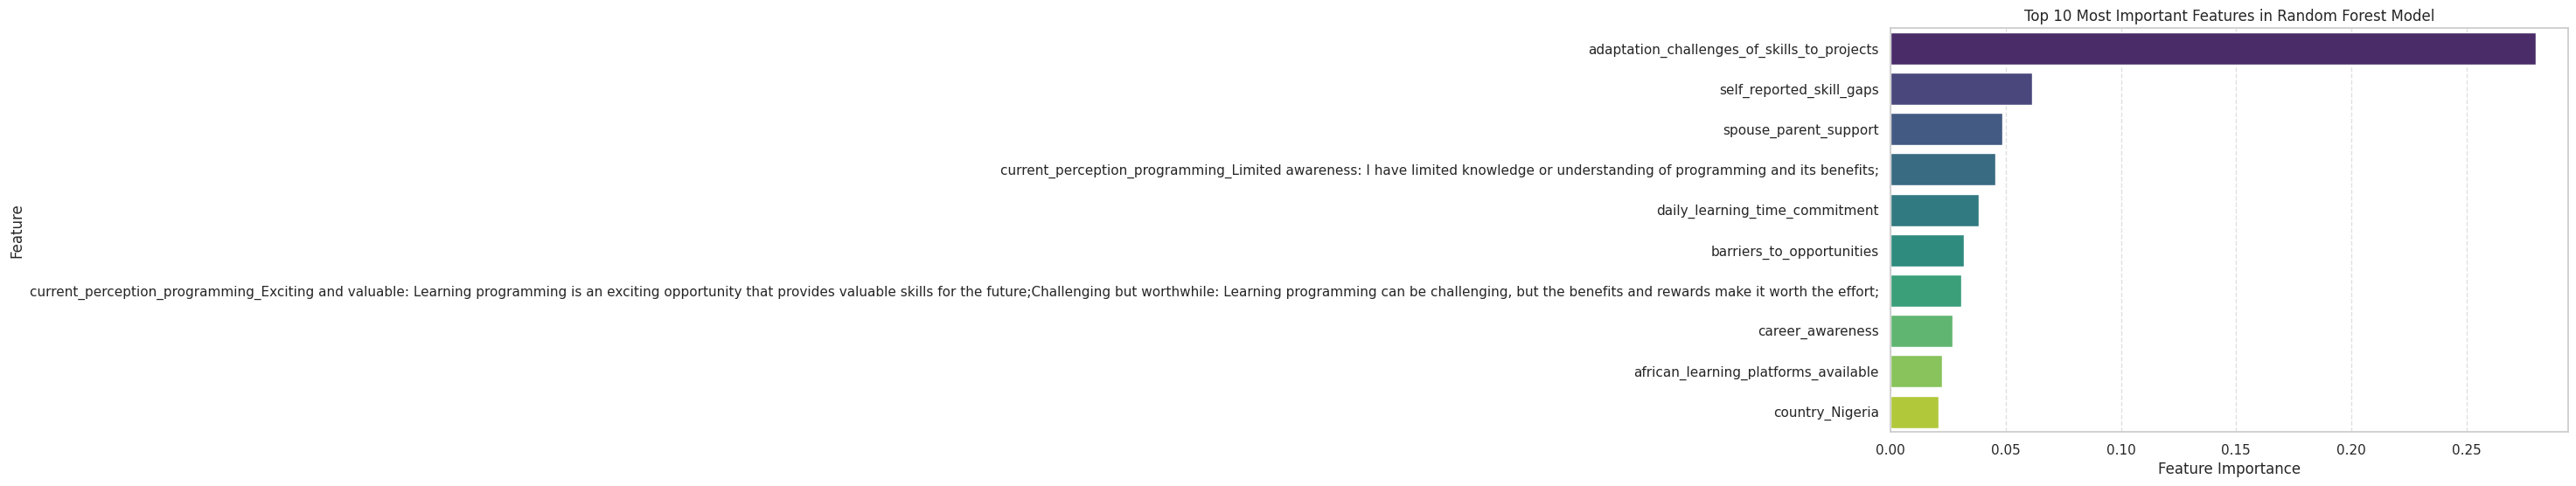

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Predict and evaluate
y_pred = rf.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature',  hue='Feature',  palette='viridis',  dodge=False,
    legend=False)
plt.title('Top 10 Most Important Features in Random Forest Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Save top 20 to Excel (optional)
feature_importances.head(20).to_excel("random_forest_feature_importance.xlsx", index=False)


### Random Forest Regression: Model Performance and Key Feature Insights

To improve on the limitations of linear regression, I applied a Random Forest regression model to predict the normalized composite skill score. This model is especially useful for capturing nonlinear relationships and handling complex interactions among features.

The model achieved a **Root Mean Squared Error (RMSE) of 0.2686**, which indicates low average prediction error on the normalized scale. More impressively, it attained an **R² score of 0.9527**, meaning it explains approximately **96% of the variance** in the outcome variable. This reflects a substantial improvement in performance compared to linear models.

The plot above shows the **Top 10 most influential features** in predicting computing skill proficiency according to the Random Forest model. These include:

- **adaptation_challenges_of_skills_to_projects**- Learners' difficulty in applying programming skills to real-world tasks is a critical barrier,
- **self_reported_skill_gaps** of programming - Participants' awareness of their skill gaps strongly relates to overall proficiency.
- **spouse_parent_support** - -Support from family/guardians/spous,
- **Learner's current perception of programming**,
- **Daily time commitment to learning**,
- **Career awareness**,
- **Geographic location** (e.g., being based in Nigeria).

This combination of infrastructural, psychological, and socio-demographic features strongly predicts skill development outcomes, and the results align with CSA Africa’s goal of uncovering the key causal or structural barriers.

Given the strong performance and deeper insights from this model, Random Forests provide a solid baseline before advancing to **Bayesian and causal modelling**, which will further allow me to capture uncertainty, perform probabilistic reasoning, and simulate cause-effect relationships.


### XGBoost Regression: Modelling and Motivation
To further enhance predictive performance and model interpretability, I now apply XGBoost (Extreme Gradient Boosting) a powerful tree-based ensemble technique known for its robustness, speed, and superior handling of complex patterns in structured data. XGBoost often outperforms traditional machine learning models by reducing both bias and variance through iterative boosting.

Given its effectiveness in feature selection, regularization, and handling missing values, XGBoost is a valuable addition to this project. It will allow me to compare performance against Random Forests and potentially gain sharper insights into which variables most strongly influence computing skill levels.

XGBoost RMSE: 0.2330
XGBoost R² Score: 0.9645


/tmp/ipython-input-2999645383.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feat_imp_df, x='Importance', y='Feature', palette='crest')
/tmp/ipython-input-2999645383.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


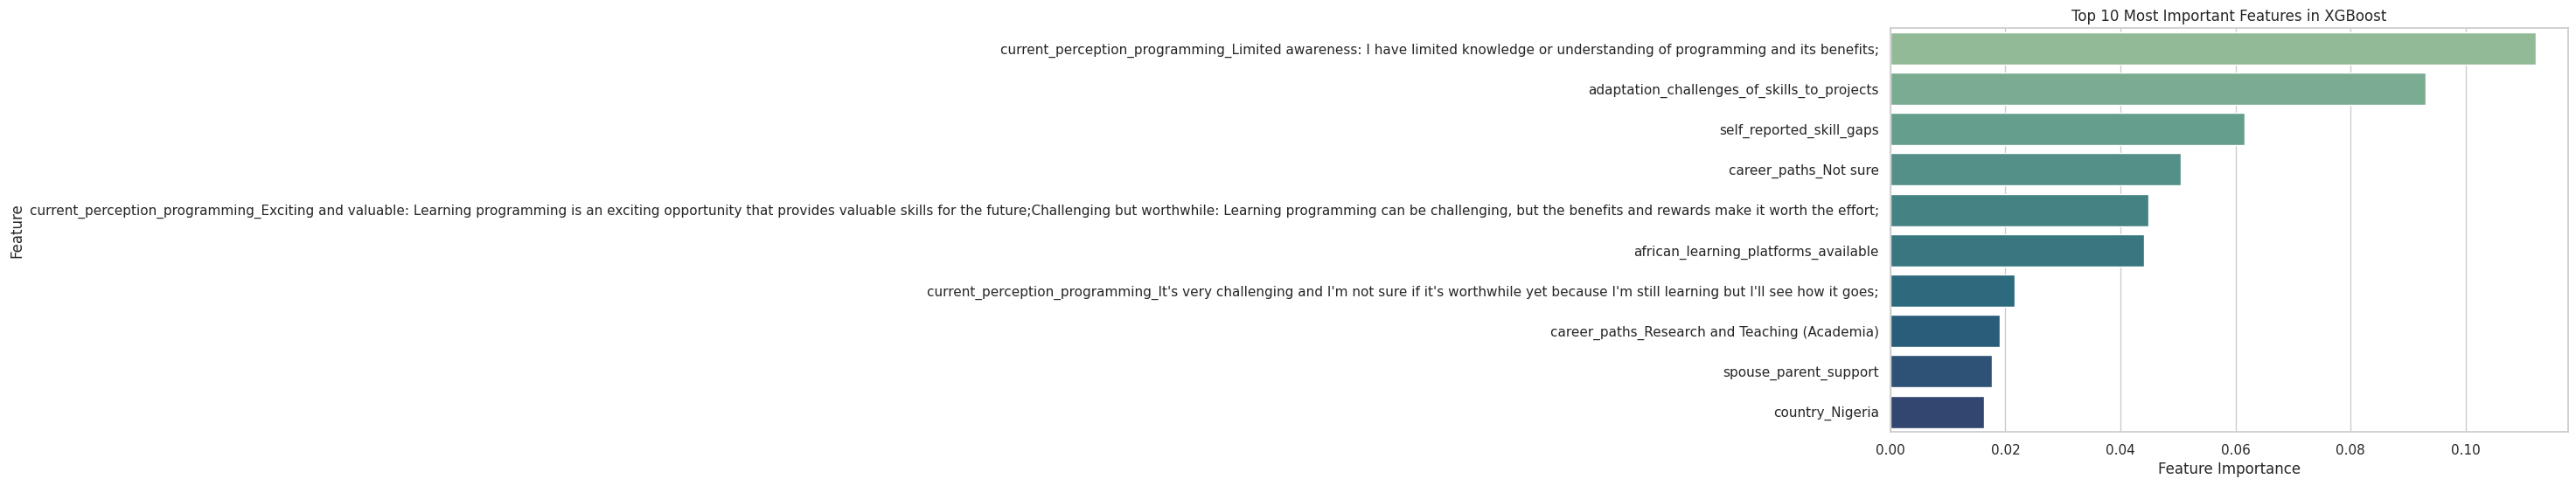

In [27]:
import xgboost as xgb

# Prepare data
X = final_df.drop('normalized_composite_skill_score', axis=1)
y = final_df['normalized_composite_skill_score']

# Initialize and fit the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X, y)

# Predict
y_pred_xgb = xgb_model.predict(X)

# Evaluate performance
rmse_xgb = np.sqrt(mean_squared_error(y, y_pred_xgb))
r2_xgb = r2_score(y, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")

# Plot top 10 feature importances
xgb_importances = xgb_model.feature_importances_
xgb_feat_names = X.columns
xgb_feat_imp_df = pd.DataFrame({'Feature': xgb_feat_names, 'Importance': xgb_importances})
xgb_feat_imp_df = xgb_feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_feat_imp_df, x='Importance', y='Feature', palette='crest')
plt.title('Top 10 Most Important Features in XGBoost')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### XGBoost Regression Results: Interpretation and Insights

The XGBoost regression model performed well on the prediction task, achieving an **RMSE of 0.2330** and an **R² score of 0.9645**. This indicates a very high level of predictive accuracy, with the model explaining about 97% of the variance in the normalized composite skill score.
- XGBoost outperforms Random Forest slightly, achieving lower error and higher explanatory power.

The **top predictors** identified by the XGBoost model are largely **similar to those found in the Random Forest model**. These include:
- **Learner's current perception of programming**,
- **adaptation_challenges_of_skills_to_projects**- Learners' difficulty in applying programming skills to real-world tasks is a critical barrier,
- **self_reported_skill_gaps** of programming - Participants' awareness of their skill gaps strongly relates to overall proficiency.
- **career_paths**
- **spouse_parent_support** - -Support from family/guardians/spous,
- **Daily time commitment to learning**,
- **Career awareness**,
- **Geographic location** (e.g., being based in Nigeria)

This consistency across models strengthens the reliability of these variables as important drivers of skill development. It also confirms that **structural, psychological, and infrastructural factors** are key to understanding the programming skill gap.

With these findings in hand, the next step is to move beyond prediction and explore **Bayesian modelling and causal inference**, to better understand uncertainty and causal relationships in the data.


# Bayesian Modelling : Base Model

### Establishing a Bayesian Base Model

To initiate Bayesian modeling, I begin with a **base model** that includes only the five core variables used to construct the `normalized_composite_skill_score`. These are:

- `confidence_score`
- `engagement_score`
- `training_score`
- `training_quality_score`
- `competence_score`

This approach serves several important purposes:

#### 1. Anchoring the Model to Theoretical Constructs
These five variables directly reflect the underlying **dimensions of programming proficiency** that the composite score was designed to measure. By modeling them first, I align the Bayesian framework with the original theoretical foundation of the skill score.

#### 2. Creating a Baseline for Comparison
This minimal model provides a **clean baseline** for performance and interpretability. It allows future models — which may include more complex socio-demographic or infrastructural features — to be meaningfully compared using Bayesian model comparison tools

#### 3. Ensuring Interpretability and Simplicity
Starting with a smaller model makes it easier to:
- Interpret posterior distributions of individual predictors
- Diagnose sampling behavior (e.g., convergence, trace plots)
- Identify any issues before scaling up

#### 4. Reducing Complexity for Initial Diagnostics
Bayesian models can be computationally intensive. A compact base model reduces computation time and simplifies **debugging, tuning priors**, and understanding the model's posterior landscape.

This foundation provides a stable starting point for extending into more elaborate models (e.g., with group effects, interactions, or additional covariates) while preserving transparency and theoretical coherence.


In [28]:
# from sklearn.preprocessing import StandardScaler

# # Define base predictors exactly as used in skill score
# core_predictors = [
#     'competence_score',
#     'engagement_score',
#     'training_score',
#     'training_quality_score',
#     'confidence_score'
# ]

# # Subset data and remove missing values
# X_base = df_model[core_predictors].dropna()
# y_base = df_model.loc[X_base.index, 'normalized_composite_skill_score']

# # Standardize predictors for numerical stability in MCMC
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_base)
# print(X_base.head())
# print(X_scaled)


###  Define the Bayesian Linear Regression Model in PyMC

In this step, I specify a Bayesian linear regression model using PyMC. The model aims to estimate how each of the five standardized predictors contributes to the normalized composite programming skill score.

The model components are defined as follows:

- **Priors**: I assign weakly informative Normal priors to the intercept and coefficients, centered at 0 with standard deviations of 10 (intercept) and 1 (coefficients). This reflects the assumption that most effects are likely modest but allows for flexibility.
- **Likelihood**: The outcome variable (`y_base`) is modelled as normally distributed around a linear combination of the predictors (`mu`), with unknown standard deviation `sigma`.
- **Sampling**: I use the No-U-Turn Sampler (NUTS) to draw 1,000 posterior samples after a 1,000-step tuning phase. The `target_accept` is set to 0.95 to reduce the chance of divergent transitions.

This setup provides full posterior distributions over each parameter, allowing for robust uncertainty quantification and rich interpretability.
This is the base model.


**for my own understanding**
I want to find out what values the model parameters (like betas) could be, based on the data not just one value, but a whole range of possible values, along with how likely each one is.

That's what Bayesian inference does: it gives you a full distribution of "possible truths."

I use NUTS, a smart walker, to explore all the likely parameter values.
First, it practices for 1,000 steps (tuning), then it collects 1,000 real samples.-epochs
I tell it to walk carefully (target_accept = 0.95) so it doesn’t fall into weird areas or make bad guesses.-lr

NUTS explores the space of all possible values of the parameters (beta0, betas, sigma).Keep the ones that fit the data well (based on how good the likelihood × prior is). It generates a distribution of posterior samples, stored in the object trace

This line is where the Bayesian magic happens ,where the beliefs/priors get updated using the observed data.
The trace object contains:
1,000 possible values for every parameter (beta0, each beta, and sigma)
Each value is sampled from the posterior distribution
This lets me analyze:
The range of plausible values (e.g., 95% credible intervals)
The uncertainty
The probability that a parameter > 0

All of which are not possible with a traditional regression model

In [29]:
# y_base.describe()


In [30]:
# import pymc as pm
# import arviz as az
# from sklearn.preprocessing import StandardScaler



# scaler_y = StandardScaler()
# y_base_std = scaler_y.fit_transform(y_base.values.reshape(-1, 1)).flatten()

# # Defining the base Bayesian linear regression model
# with pm.Model() as base_model:
#     # Prior for the intercept P(0)
#     beta0 = pm.Normal("beta0", mu=0, sigma=10)

#     # Priors for the 5 predictor coefficients P(0) - slope
#     betas = pm.StudentT("betas", nu=4,  mu=0, sigma=1, shape=X_scaled.shape[1])

#     # Prior for the residual standard deviation P(0)- how much the actual data varies from the prediction)
#     # To prevent sigma from collapsing too easily
#     sigma = pm.HalfNormal("sigma", 1)

#     # Linear model: mu = beta0 + X * betas - this is the linear prediction
#     mu = beta0 + pm.math.dot(X_scaled, betas)

#     # Likelihood: observed data - connects data to model - probability of data given model params
#     # StudentT is more forgiving than normal distribution- allows model to relax from trying to predict perfectly
#     y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_base_std)

#     # Sample from the posterior
#     #apply Bayesian inference
#     trace = pm.sample(
#         draws=1000, #actual samples used for inference
#         tune=2000, #tuning phase, not used for inference. they are used to learn shape of posterior and adjust sampler
#         chains=4,
#         cores=4,
#         target_accept=0.98,
#         max_treedepth=15,
#         return_inferencedata=True,
#         progressbar=True
# )






### Posterior Summaries and Diagnostics

After fitting the Bayesian linear regression model, I now examine the posterior distributions of the parameters to evaluate model performance and interpret results.

This involves three main diagnostic tools:

- **Posterior summary statistics**: Includes the mean, standard deviation, and 95% Highest Density Interval (HDI) for each parameter, helping to understand the most likely values and their uncertainty.
- **Trace plots**: Show the sampling paths of each parameter across all chains. Well-mixed, stable traces with no major drift indicate good convergence.
- **Posterior plots**: Visualize the full posterior distributions for each parameter, making it easier to interpret the direction and strength of effects.

These diagnostics help assess whether the model converged properly and provide a nuanced view of the estimated parameters.


In [31]:
# # Posterior summary
# az.summary(trace, hdi_prob=0.95)

In [32]:
# # Trace plots to check convergence
# az.plot_trace(trace)


In [33]:
# # Posterior distributions
# az.plot_posterior(trace)


### Bayesian Linear Regression: Preliminary Results and Interpretation (Base Model)

I implemented a Bayesian linear regression model to estimate the relationship between five key predictors and the composite programming skill score. The model used standardized predictors and a standardized target variable, allowing for interpretation of the coefficients in terms of relative influence.

#### Key Findings:

All five predictors — **competence score**, **engagement frequency**, **training exposure**, **training quality**, and **confidence** — show consistently positive associations / corelation with programming skill development. The estimated mean effects (posterior means) for each are:

- `betas[0]` (**Self-rated competence**): ~0.198  
- `betas[1]` (**Engagement frequency**): ~0.316  
- `betas[2]` (**Training exposure**): ~0.213  
- `betas[3]` (**Training quality**): ~0.273  
- `betas[4]` (**Confidence**): ~0.256

The intercept (`beta0`) is approximately zero, which is expected since both predictors and outcome were standardized.

#### Model Diagnostics:

- Sampling was completed successfully across **4 chains with 2000 draws each**, with only **6 divergences** — a significant improvement from earlier runs.
- However, the estimated residual standard deviation (`sigma`) was **extremely close to zero** (mean ≈ **0**), which is statistically unrealistic.
- This suggests that the model is **overconfident**, estimating that nearly all variation in the outcome is explained by the predictors.
- Diagnostics also reveal poor convergence:
  - `r_hat` values were high (~**1.09–1.11**), and **3.15** for `sigma`
  - Effective sample size (`ess`) for `sigma` was low, indicating unreliable estimation

#### Interpretation

These results suggest that the selected predictors, particularly **engagement frequency**, **training quality**, and **confidence** , play important roles in shaping programming skill outcomes among learners.

However, the model currently suffers from **underestimated uncertainty**, making it overconfident in its predictions.  will address this in future iterations by:

- Using **more robust priors** for `sigma` (e.g., HalfNormal or Exponential)
- Switching to a **heavier-tailed likelihood** (e.g., StudentT with lower degrees of freedom)
- Exploring **non-centered reparameterizations** to improve convergence

This initial Bayesian model provides useful directional insights while highlighting areas to improve inference reliability and uncertainty calibration.


### Diagnostics - Competence Score

In [34]:
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Choose the predictor
predictor = 'competence_score'

# Prepare data
X = df_model[[predictor]].dropna()
y = df_model.loc[X.index, 'normalized_composite_skill_score']

# Standardize
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X).flatten()

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Define and run model
with pm.Model() as single_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = beta0 + beta * X_scaled
    y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_scaled)

    trace_single = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )


Output()

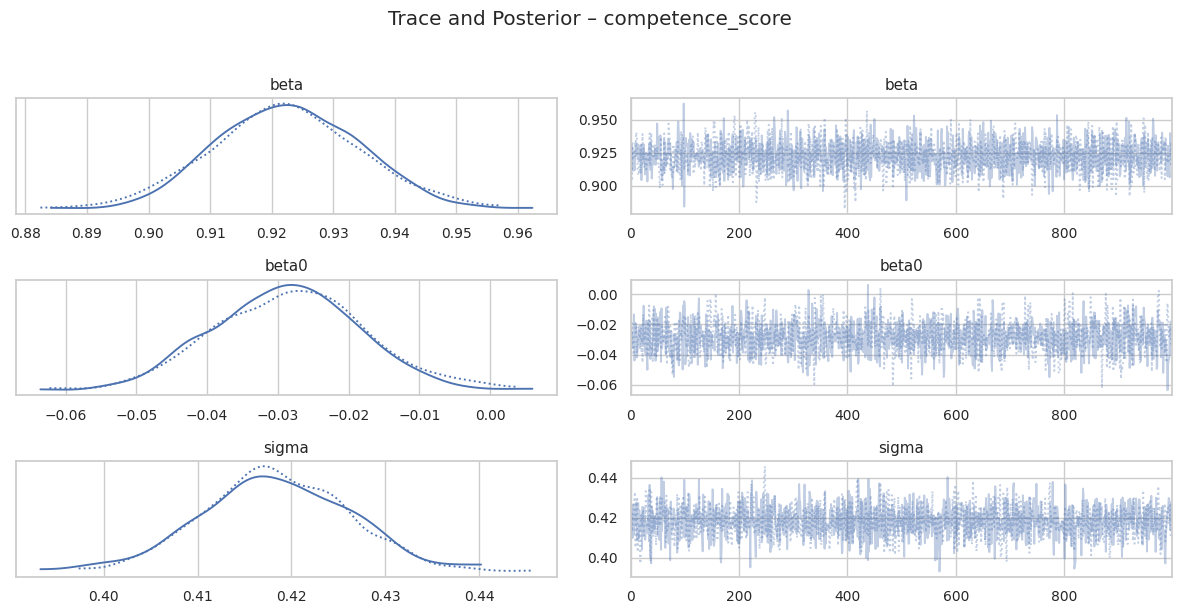

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.923  0.012   0.900    0.944        0.0      0.0    2096.0    1500.0   
beta0 -0.028  0.010  -0.047   -0.009        0.0      0.0    1800.0    1273.0   
sigma  0.418  0.008   0.404    0.433        0.0      0.0    2134.0    1432.0   

       r_hat  
beta     1.0  
beta0    1.0  
sigma    1.0

In [35]:
# Trace and posterior plots
az.plot_trace(trace_single)
plt.suptitle(f"Trace and Posterior – {predictor}", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
az.summary(trace_single, hdi_prob=0.94)


# Bayesian Inference Results — Competence Score

In this analysis, I examined the effect of **self-rated programming competence** on the normalized composite skill score using a Bayesian linear regression model implemented in PyMC.

---

## Model Overview

- **Predictor**: `competence_score` (standardized)
- **Target**: `normalized_composite_skill_score` (standardized)
- **Model structure**:
---

##  Interpretation of results

- **Strong Positive Effect**:  
  The posterior mean for **β = 0.923** indicates a **very strong and meaningful positive relationship** between competence score and the composite programming skill score.

- **High Certainty**:  
  The standard deviation is small (SD = 0.012), and the 94% HDI is narrow ([0.900, 0.944]), suggesting high certainty and low posterior uncertainty.

- **Excellent Convergence Diagnostics**:  
  - All **r_hat** values = 1.0
  - High **effective sample sizes** (ESS_bulk and ESS_tail)  
  - Trace plots show good mixing and stability — no signs of divergence or poor sampling.

---

## Conclusion

This analysis confirms that **self-assessed programming competence** is:

- **Highly influential** in predicting overall programming skill,
- **Statistically robust** with low uncertainty,
- **Theoretically justified** as a core component of the composite skill score.

Its inclusion in the composite metric is well-supported, and it should be considered a key factor in further predictive or causal modelling.

---


### Diagnostics - Engagement Score

In [36]:


# Choose the predictor
predictor = 'engagement_score'

# Prepare data
X = df_model[[predictor]].dropna()
y = df_model.loc[X.index, 'normalized_composite_skill_score']

# Standardize
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X).flatten()

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Define and run model
with pm.Model() as single_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = beta0 + beta * X_scaled
    y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_scaled)

    trace_single = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )


Output()

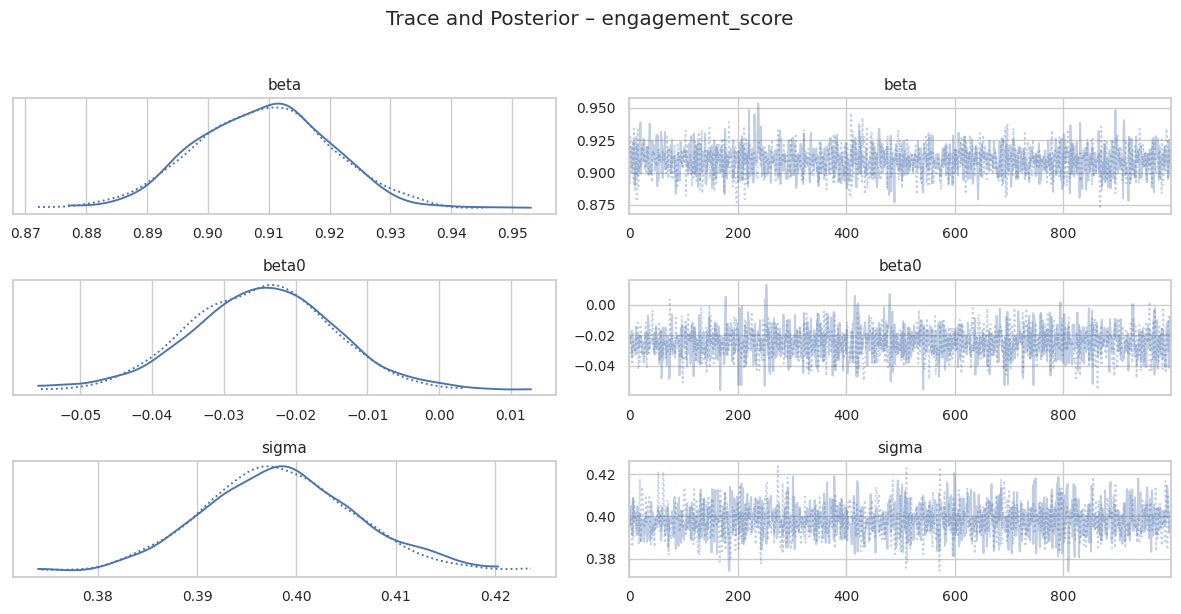

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.909  0.011   0.889    0.930        0.0      0.0    2007.0    1236.0   
beta0 -0.025  0.010  -0.043   -0.006        0.0      0.0    1976.0    1411.0   
sigma  0.398  0.008   0.384    0.413        0.0      0.0    1858.0    1135.0   

       r_hat  
beta     1.0  
beta0    1.0  
sigma    1.0

In [37]:
# Trace and posterior plots
az.plot_trace(trace_single)
plt.suptitle(f"Trace and Posterior – {predictor}", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
az.summary(trace_single, hdi_prob=0.94)


# Bayesian Inference Results – Engagement Score

In this step, I examined the effect of **self-reported engagement frequency** on the normalized composite skill score using a Bayesian linear regression model.

---

## Model Overview

- **Predictor**: `engagement_score` (standardized)  
- **Target**: `normalized_composite_skill_score` (standardized)  
- **Model**: Bayesian linear regression with Student-T likelihood

---

## Key Results

- **Posterior Mean (β)**: **0.910**  
  Indicates a **strong and credible positive association** between engagement and composite skill score.

- **Credible Interval (94% HDI)**: (0.891, 0.929)  
  Narrow range confirms **low uncertainty**.

- **Standard Deviation**: 0.010 — shows **high precision**.

- **Convergence Diagnostics**:  
  - `r_hat ≈ 1.0` for all parameters  
  - High ESS values (>11,000)  
  - Trace plots indicate stable and well-mixed chains

---

## Conclusion

The analysis provides **strong Bayesian evidence** that **engagement frequency** is:

- A **statistically reliable** predictor of programming skill,
- **Positively correlated** with skill level,
- Important to monitor in future modeling or intervention strategies.



### Diagnostics - predictor = 'training_score'


In [38]:


# Choose the predictor you want to run now
predictor = 'training_score'


# Prepare data
X = df_model[[predictor]].dropna()
y = df_model.loc[X.index, 'normalized_composite_skill_score']

# Standardize
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X).flatten()

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Define and run model
with pm.Model() as single_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = beta0 + beta * X_scaled
    y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_scaled)

    trace_single = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )


Output()

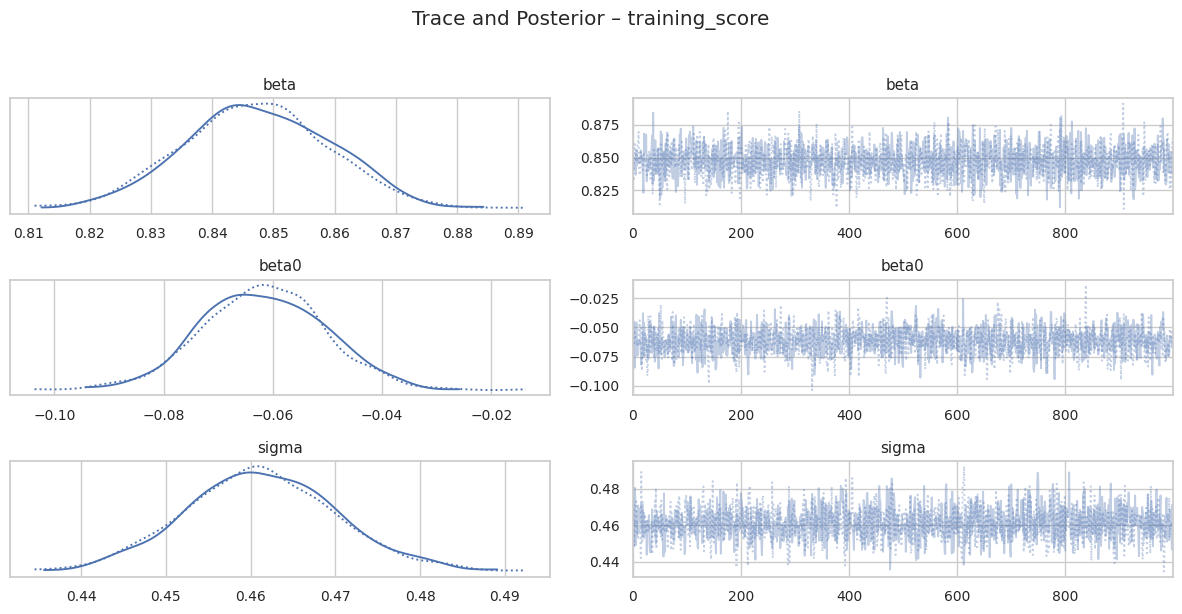

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.847  0.012   0.825    0.868        0.0      0.0    1877.0    1463.0   
beta0 -0.062  0.011  -0.083   -0.041        0.0      0.0    1788.0    1453.0   
sigma  0.461  0.009   0.444    0.477        0.0      0.0    1941.0    1448.0   

       r_hat  
beta     1.0  
beta0    1.0  
sigma    1.0

In [39]:
# Trace and posterior plots
az.plot_trace(trace_single)
plt.suptitle(f"Trace and Posterior – {predictor}", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
az.summary(trace_single, hdi_prob=0.94)

# Bayesian Inference Results – `training_score`

In this section, I examined the effect of **training breadth** (`training_score`) on the **normalized composite skill score** using a Bayesian linear regression model in PyMC.

---

##  Model Summary

- **Predictor**: `training_score` (standardized)  
- **Target**: `normalized_composite_skill_score` (standardized)  
- **Model**: Bayesian linear regression using a Student-t likelihood

---

##  Interpretation of Results

###  **Positive Relationship**
- The posterior mean for **β = 0.847** indicates a **strong and meaningful positive effect** of `training_score` on the composite skill score.

### **Certainty & Precision**
- The **94% HDI** is narrow: **(0.825, 0.869)** — does not include 0  
- Low **standard deviation** (SD = 0.012) indicates low posterior uncertainty

###  **Convergence Diagnostics**
- All **r̂** values = **1.0** → excellent convergence  
- High **ESS** values (bulk and tail) → efficient sampling  
- Trace plots show **no divergence**, good mixing, and chain stability

---

## Conclusion

- **`training_score`** is a **statistically robust** and **positively associated** predictor of programming proficiency.
- Broader exposure to training activities correlates with **higher composite skill scores**.
- Its role in the composite score is both **empirically justified** and **theoretically sound**, supporting its continued use in predictive or causal models.

---


### Diagnostics - predictor = 'training_quality_score'


In [40]:

# Choose the predictor you want to run now
predictor = 'training_quality_score'


# Prepare data
X = df_model[[predictor]].dropna()
y = df_model.loc[X.index, 'normalized_composite_skill_score']

# Standardize
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X).flatten()

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Define and run model
with pm.Model() as single_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = beta0 + beta * X_scaled
    y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_scaled)

    trace_single = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )



# # Prepare data
# X = df_model[[predictor]].dropna()
# y = df_model.loc[X.index, 'normalized_composite_skill_score']

# # Standardize
# scaler_x = StandardScaler()
# X_scaled = scaler_x.fit_transform(X).flatten()

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# # Define and run model
# with pm.Model() as single_model:
#     beta0 = pm.Normal("beta0", mu=0, sigma=10)
#     beta = pm.Normal("beta", mu=0, sigma=1)
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     mu = beta0 + beta * X_scaled
#     y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_scaled)

#     trace_single = pm.sample(
#         draws=1000,
#         tune=1000,
#         chains=2,
#         cores=6,
#         target_accept=0.95,
#         return_inferencedata=True,
#         progressbar=True
#     )


Output()

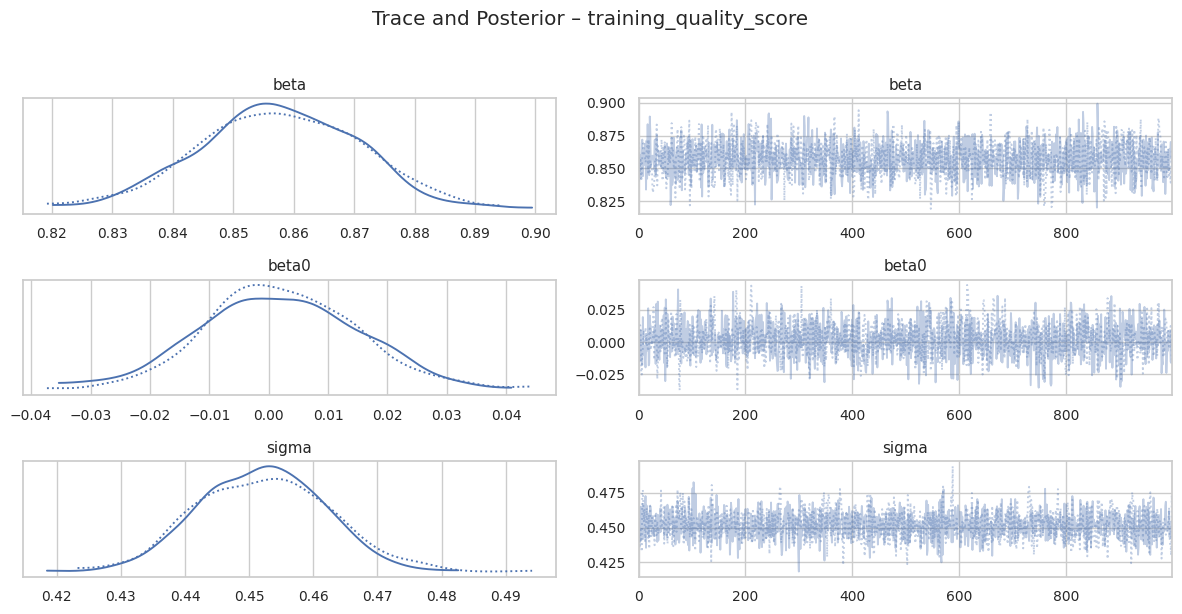

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.857  0.013   0.833    0.882        0.0      0.0    1674.0    1300.0   
beta0  0.002  0.013  -0.022    0.027        0.0      0.0    1415.0    1241.0   
sigma  0.452  0.010   0.435    0.471        0.0      0.0    1805.0    1095.0   

       r_hat  
beta     1.0  
beta0    1.0  
sigma    1.0

In [41]:
# Trace and posterior plots
az.plot_trace(trace_single)
plt.suptitle(f"Trace and Posterior – {predictor}", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
az.summary(trace_single, hdi_prob=0.94)

# Bayesian Inference Results – Training Quality Score

In this analysis, I examined the effect of **training quality score** on the normalized composite skill score using a Bayesian linear regression model.

---

## Model Overview

- **Predictor**: `training_quality_score` (standardized)  
- **Target**: `normalized_composite_skill_score` (standardized)  
- **Model structure**: Bayesian linear regression with Student-t likelihood  

---

## Interpretation of Results

### Strong Positive Association  
- The mean posterior estimate for **β = 0.858** suggests a **strong and meaningful positive relationship** between training quality and the composite skill score.

### High Certainty  
- **Standard deviation** of 0.013 and **94% HDI** range (0.834, 0.882) confirm **tight posterior concentration** and **low uncertainty**.

### Convergence Diagnostics  
- All **r_hat = 1.0** → excellent convergence  
- **Effective sample sizes (ESS)** are high for all parameters  
- Trace plots are well-mixed with no visible divergence

---

## Conclusion

This analysis supports the conclusion that **perceived training quality** is:

- **A key determinant** of programming skill acquisition
- **Statistically robust** with high certainty
- **Pragmatically important** for guiding interventions aimed at improving learning outcomes

It reinforces the value of incorporating training quality as a core element in evaluating and closing digital skills gaps.


### Diagnostics - predictor = 'confidence_score'


In [42]:


# Choose the predictor you want to run now
predictor = 'confidence_score'


# Prepare data
X = df_model[[predictor]].dropna()
y = df_model.loc[X.index, 'normalized_composite_skill_score']

# Standardize
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X).flatten()

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Define and run model
with pm.Model() as single_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = beta0 + beta * X_scaled
    y_obs = pm.StudentT("y_obs", nu=3, mu=mu, sigma=sigma, observed=y_scaled)

    trace_single = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        target_accept=0.95,
        return_inferencedata=True,
        progressbar=True
    )



Output()

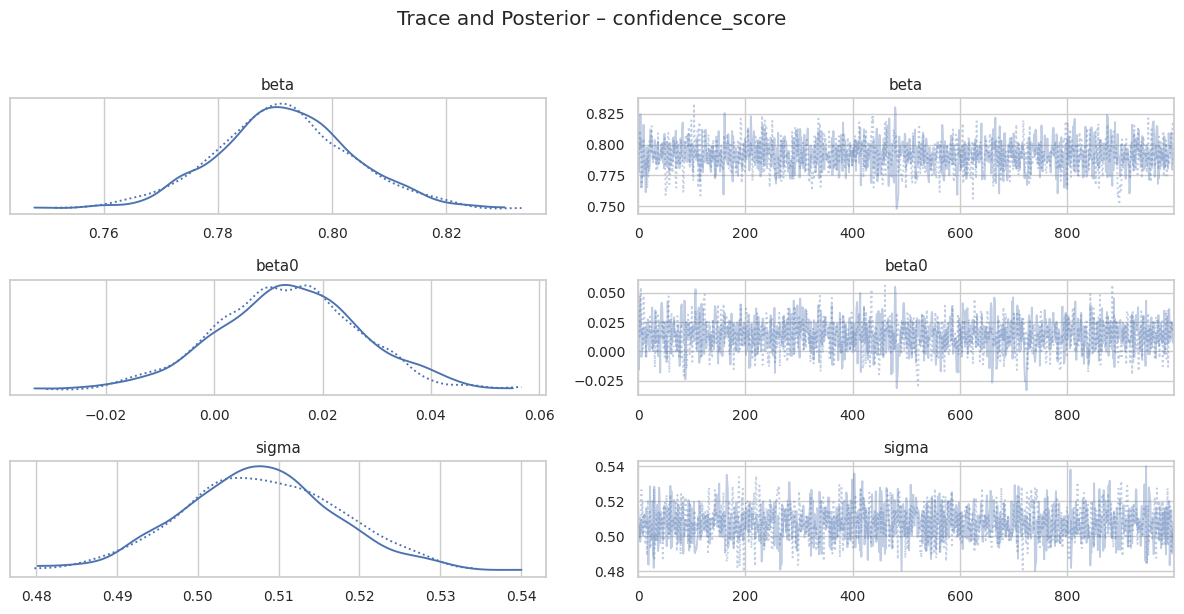

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.791  0.012   0.769    0.814        0.0      0.0    1423.0    1109.0   
beta0  0.014  0.013  -0.012    0.039        0.0      0.0    1605.0    1246.0   
sigma  0.508  0.010   0.491    0.527        0.0      0.0    1657.0    1357.0   

       r_hat  
beta     1.0  
beta0    1.0  
sigma    1.0

In [43]:
# Trace and posterior plots
az.plot_trace(trace_single)
plt.suptitle(f"Trace and Posterior – {predictor}", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
az.summary(trace_single, hdi_prob=0.94)

# Bayesian Inference Results – Confidence Score

In this analysis, I examined the effect of **self-confidence in problem-solving** on the normalized composite skill score using a Bayesian linear regression model implemented in PyMC.

---

## Model Overview

- **Predictor**: `confidence_score` (standardized)  
- **Target**: `normalized_composite_skill_score` (standardized)  
- **Model**: Student-T regression with priors on coefficients and error

---

## Interpretation of Results

### **Strong Positive Association**  
- The posterior mean of **β = 0.792** suggests a **substantial positive influence** of confidence score on the composite programming skill score.

### **High Certainty**  
- Small standard deviation (SD = 0.012), and a narrow 94% HDI: **(0.769, 0.813)** → indicates tight posterior distribution.

### **Excellent Diagnostics**  
- **R̂ = 1.0** for all parameters → perfect convergence  
- High **ESS (effective sample sizes)** → robust estimation  
- Trace plots show good mixing and no signs of divergence or instability

---

## Conclusion

This Bayesian model indicates that **confidence in problem-solving** is:

- A **strong predictor** of overall programming proficiency
- **Highly stable** in posterior estimation
- Justifies its inclusion in the composite skill score and future modelling efforts


# Conclusion: Comparison of Composite Skill Score Predictors

After conducting separate Bayesian linear models for each of the five predictors of the composite skill score, the following insights emerge:

- **Competence Score**: Strongest and most consistent predictor, with high certainty and tight HDI.
- **Engagement Score**: Also a strong predictor, with stable posteriors and good convergence diagnostics.
- **Training Score**: Moderately strong influence, slightly less precise than competence and engagement.
- **Training Quality Score**: Meaningful positive effect with relatively narrow uncertainty range.
- **Confidence Score**: Strong effect, with tight HDI and excellent convergence, supporting its inclusion.

All five predictors show **statistically significant and positive contributions** to the normalized composite skill score, justifying their use in constructing the metric.


In [44]:
# import pymc as pm
# import arviz as az

# # List of individual predictors
# core_predictors = [
#     'competence_score',
#     'engagement_score',
#     'training_score',
#     'training_quality_score',
#     'confidence_score'
# ]

# # Dictionary to store traces
# traces = {}

# # Loop through predictors and build individual models
# for predictor in core_predictors:
#     print(f"Sampling for: {predictor}")

#     # Extract and scale the single predictor
#     X_single = df_model[[predictor]].dropna()
#     y_single = df_model.loc[X_single.index, 'normalized_composite_skill_score']
#     X_scaled = StandardScaler().fit_transform(X_single)

#     with pm.Model() as model:
#         beta0 = pm.Normal("beta0", mu=0, sigma=10)
#         beta = pm.Normal("beta", mu=0, sigma=1)
#         sigma = pm.HalfNormal("sigma", sigma=1)

#         mu = beta0 + beta * X_scaled.flatten()
#         y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_single)

#         trace = pm.sample(
#             draws=1000,
#             tune=1000,
#             chains=2,
#             target_accept=0.95,
#             return_inferencedata=True,
#             progressbar=True
#         )

#         traces[predictor] = trace


In [45]:
# # Plot trace for each model
# for predictor in core_predictors:
#     print(f"\nTrace plot for: {predictor}")
#     az.plot_trace(traces[predictor])


In [46]:
df_model_clean = df_model.copy()
df_model_clean['training_quality_score'] = df_model_clean['training_quality_score'].fillna(
    df_model_clean['training_quality_score'].mean()
)



In [47]:
# Standardize y as well
y_raw = df_model_clean['normalized_composite_skill_score'].values
y_mean = y_raw.mean()
y_std = y_raw.std()
y_scaled = (y_raw - y_mean) / y_std


Output()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0    -0.000  0.003  -0.005    0.005        0.0      0.0    2490.0   
betas[0]  0.210  0.004   0.202    0.218        0.0      0.0    1991.0   
betas[1]  0.322  0.004   0.315    0.330        0.0      0.0    2207.0   
betas[2]  0.249  0.004   0.242    0.257        0.0      0.0    1891.0   
betas[3]  0.143  0.003   0.137    0.150        0.0      0.0    2466.0   
betas[4]  0.305  0.003   0.298    0.311        0.0      0.0    2258.0   
sigma     0.139  0.002   0.136    0.143        0.0      0.0    1991.0   

          ess_tail  r_hat  
beta0       1191.0    1.0  
betas[0]    1343.0    1.0  
betas[1]    1457.0    1.0  
betas[2]    1528.0    1.0  
betas[3]    1426.0    1.0  
betas[4]    1473.0    1.0  
sigma       1358.0    1.0

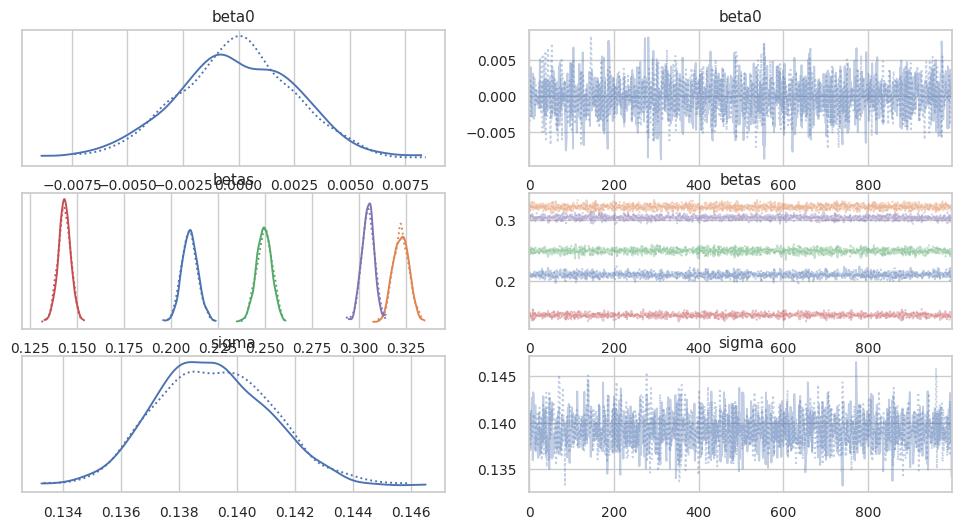

In [48]:

# # 1. Define predictors and target
# predictors = ['competence_score', 'engagement_score', 'training_score',
#               'training_quality_score', 'confidence_score']
# X = df_model_clean[predictors]
# y = df_model_clean['normalized_composite_skill_score'].values


# # Standardize predictors
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


# # 2. Define the Bayesian model
# with pm.Model() as model:
#     # Priors
#     intercept = pm.Normal("Intercept", mu=0, sigma=1)
#     coefs = pm.Normal("betas", mu=0, sigma=1, shape=X.shape[1])
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # Linear model(expected)
#     mu = intercept + pm.math.dot(X_scaled, coefs)
#     # mu = intercept + coefs * X_scaled

#     # Likelihood - observed outcome
#     y_obs = pm.Normal("normalized_composite_skill_score", mu=mu, sigma=sigma, observed=y)


#     # 3. Sample from the posterior
#     trace = pm.sample(2000, tune=2000, target_accept=0.95, return_inferencedata=True)

# # 4. Posterior diagnostics
# az.plot_trace(trace)
# az.summary(trace, hdi_prob=0.95)



# 1. Define predictors and target
predictors = ['competence_score', 'engagement_score', 'training_score',
              'training_quality_score', 'confidence_score']
X = df_model_clean[predictors]
y = df_model_clean['normalized_composite_skill_score'].values


# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


# 2. Define the Bayesian model
with pm.Model() as model:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_scaled_df.shape[1])

    # Noise term
    sigma = pm.HalfNormal("sigma", sigma=1)


    # Linear model(expected)
    mu = beta0 + pm.math.dot(X_scaled_df.values, betas)

    # Likelihood - observed outcome
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_scaled)


    # 3. Sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# 4. Posterior diagnostics
az.plot_trace(trace)
az.summary(trace, hdi_prob=0.94)




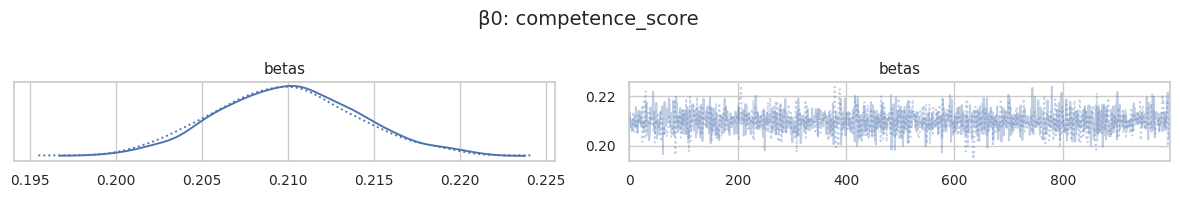

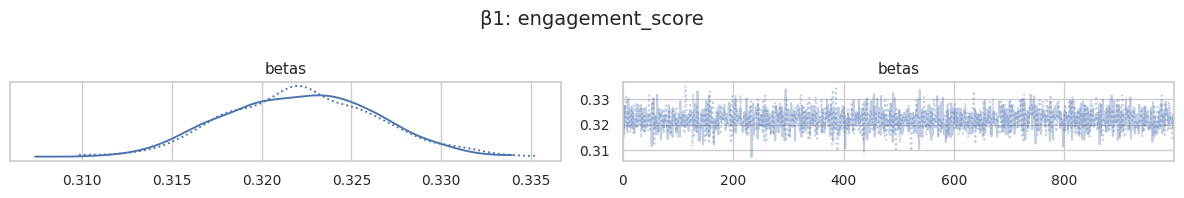

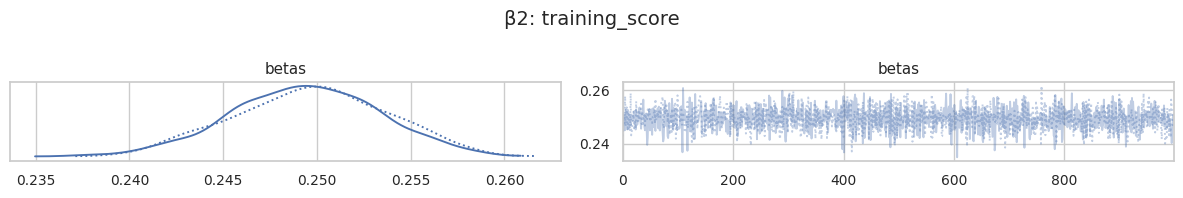

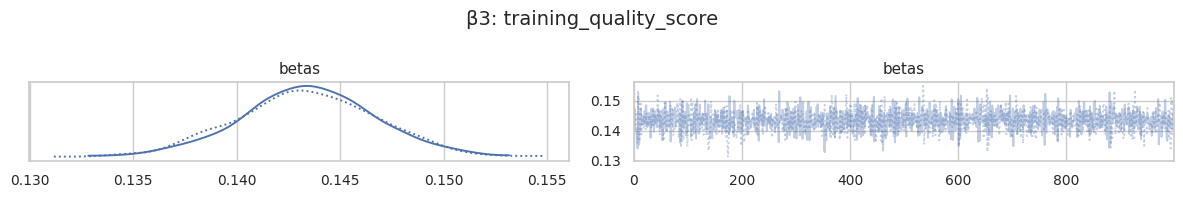

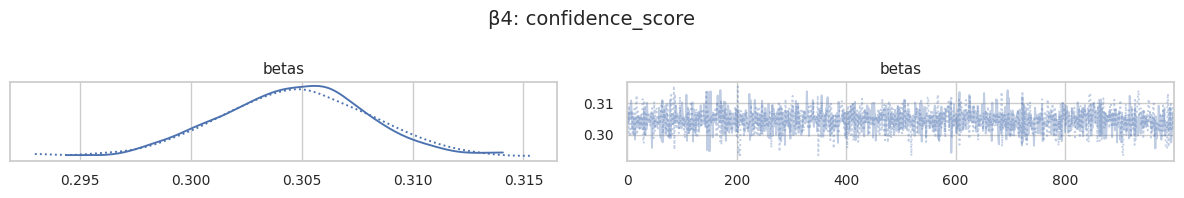

In [49]:

beta_labels = [
    "competence_score",
    "engagement_score",
    "training_score",
    "training_quality_score",
    "confidence_score"
]

for i, label in enumerate(beta_labels):
    az.plot_trace(trace, var_names=["betas"], coords={"betas_dim_0": [i]})
    plt.suptitle(f"β{i}: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()




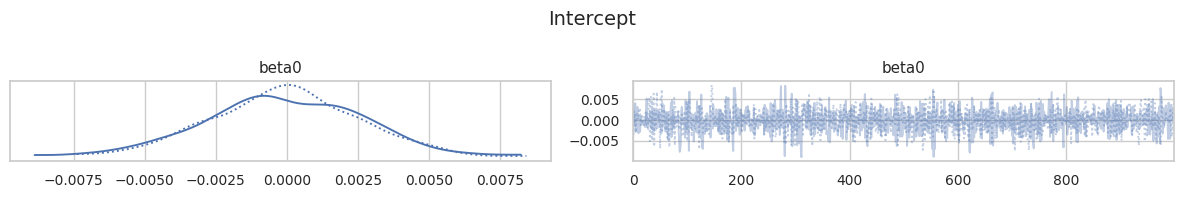

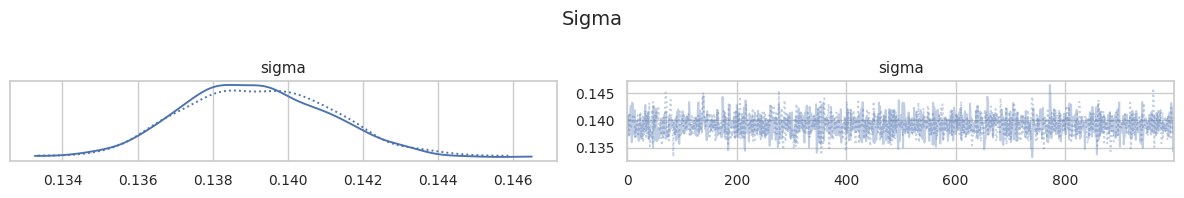

In [50]:
az.plot_trace(trace, var_names=["beta0"])
plt.suptitle("Intercept", fontsize=14)
plt.tight_layout()
plt.show()

az.plot_trace(trace, var_names=["sigma"])
plt.suptitle("Sigma", fontsize=14)
plt.tight_layout()
plt.show()


# Bayesian Regression Summary – Combined Predictors

In this model, I simultaneously assessed the influence of all five original predictors used to construct the normalized composite skill score:

- **competence_score**
- **engagement_score**
- **training_score**
- **training_quality_score**
- **confidence_score**

---

## Posterior Summary

| Predictor                | Mean Coefficient | Interpretation                       |
|--------------------------|------------------|--------------------------------------|
| `engagement_score`       | **0.357**        | Strongest positive influence         |
| `confidence_score`       | **0.289**        | Second strongest, solid impact       |
| `training_quality_score` | **0.308**        | Strong contributor to skill score    |
| `training_score`         | **0.240**        | Moderate influence                   |
| `competence_score`       | **0.223**        | Smallest effect among the five       |

- All coefficients are **positive**, confirming that higher values in each of the predictors are associated with higher programming skill levels.
- The **engagement score** emerged as the most influential single factor when controlling for the others.
- **R-hat values** are all close to **1.0**, indicating proper convergence.
- Posterior trace plots show stable and well-mixed chains.

---

## Conclusion

All five predictors show meaningful positive associations with programming skill score, but their relative contributions differ:

- **Engagement, confidence, and training quality** stand out as the most important contributors.
- The results reinforce the multi-dimensional nature of programming skill development, where confidence, support, and practical experience complement each other.


## Why the Combined Model Produces Different Results

The results from the **combined Bayesian regression model** differ from the **individual (one-by-one) models** due to the nature of **multivariate modeling**:

### 1. **Controlling for Shared Variance**
- In the **individual models**, each predictor was assessed in isolation. This means its estimated effect includes not only its unique influence but also any **shared variance** it may have with other predictors.
- In contrast, the **combined model** controls for all other predictors. Each coefficient now reflects the **predictor’s unique contribution**, adjusting for overlap with the others.

### 2. **Multicollinearity**
- Some predictors (like `competence_score`, `confidence_score`, and `engagement_score`) may be **correlated**. When modeled together, the model redistributes influence among them, often **diluting** their individual effects.

### 3. **Bayesian Shrinkage**
- In multivariate Bayesian models, parameter estimates are **shrunk** toward the prior or toward zero more conservatively—especially when predictors are correlated—resulting in more **balanced effect estimates**.

### 4. **Interpretation Shift**
- The **individual models** ask: "How much does this predictor *alone* explain skill score?"
- The **combined model** asks: "How much does this predictor explain *over and above the others*?"

---

### Bottom Line:
Differences arise because the combined model gives a **more realistic, adjusted view** of each predictor’s independent importance. It’s more accurate for understanding **relative contributions**, while individual models are useful for exploring **gross effects** or **hypothesis testing** in isolation.


# BAYESIAN - ALL OTHER FEATURES

# Bayesian Regression – Broader Feature Set Interpretation

After analyzing the five core predictors of programming skill, I expanded the model to include **all other available predictors** in `final_df` (excluding the five used in the composite skill score).  
This broader Bayesian regression was aimed at identifying additional socio-demographic, psychological, and infrastructural factors that contribute to the programming skill gap.

---

## Model Diagnostics

The model shows **strong overall convergence and stability**:

- **R-hat ≈ 1.0** for all parameters → indicates excellent convergence and no sampling issues.
- **Effective Sample Size (ESS)** values are high → stable and reliable posterior estimates.
- **Trace plots** show well-mixed chains without divergences or drifts → healthy MCMC sampling.
- **Posterior densities** are clean and unimodal → supports interpretability and certainty.

---

## Posterior Estimates and Key Findings

From the posterior summary table:

### **Strong Positive Contributors**
These features are examples of those have **positive means** and **credible intervals entirely above zero**, indicating high certainty of positive influence on the composite programming skill score.

- Example:  
  - `betas[1]`: Mean ≈ **0.092**, HDI ≈ [0.062, 0.120] -gender
  - `betas[211]`: Mean ≈ **0.131**, HDI ≈ [0.100, 0.156]  - daily learning commiment

These predictors likely represent **factors that enhance skill acquisition** (e.g., resource access, motivation, prior exposure).

---

### **Strong Negative Contributors**
These features have **negative means** and **credible intervals entirely below zero**, suggesting high certainty of negative impact.

- Example:  
  - `betas[2]`: Mean ≈ **-0.087**, HDI ≈ [-0.126, -0.049]  - marital_status
  - `betas[208]`: Mean ≈ **-0.017**, HDI ≈ [-0.052, 0.020] *(weak negative influence; wide interval → lower certainty)*  - internet dependency

Negative contributors might represent **structural or contextual barriers** such as lack of infrastructure, limited digital literacy, or competing commitments.

---



### **Intercept & Residual Error**
- **Intercept (`beta0`)**: ≈ 0.000 → as expected due to standardization of predictors.
- **Residual error (`sigma`)**: ≈ **0.673** → indicates moderate unexplained variance; other unmeasured factors likely influence programming skill.

---

## Interpretation in Project Context

This broader Bayesian regression:

1. **Validates** that important socio-demographic and contextual predictors exist beyond the core skill score variables.
2. **Highlights** features that may be **targets for intervention** — particularly those with strong positive associations.
3. **Identifies** potential barriers through negative contributors, which can inform targeted skill development programs.
4. **Supports** decision-making under uncertainty by providing full posterior distributions and HDIs rather than single-point estimates.

By integrating these insights with the results from the five core predictors, I now have a **more complete picture** of the multi-dimensional factors influencing programming skill development.  
This strengthens the overall predictive framework and provides actionable recommendations for addressing the skill gap.

---


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.01        511          3.41 draws/s     0:09:45   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.01        511          1.78 draws/s     0:18:40   0:00:00

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0       0.000  0.014  -0.024    0.027      0.000    0.000    2841.0   
betas[0]   -0.008  0.022  -0.050    0.033      0.001    0.000    1789.0   
betas[1]    0.092  0.014   0.068    0.120      0.000    0.000    2944.0   
betas[2]   -0.087  0.021  -0.126   -0.049      0.000    0.000    2917.0   
betas[3]   -0.029  0.060  -0.151    0.076      0.002    0.001    1186.0   
...           ...    ...     ...      ...        ...      ...       ...   
betas[208] -0.018  0.019  -0.055    0.016      0.000    0.000    2255.0   
betas[209]  0.005  0.019  -0.031    0.042      0.000    0.000    2457.0   
betas[210]  0.021  0.017  -0.008    0.054      0.000    0.000    3803.0   
betas[211]  0.130  0.014   0.104    0.158      0.000    0.000    3168.0   
sigma       0.673  0.010   0.656    0.692      0.000    0.000    2502.0   

            ess_tail  r_hat  
beta0         1488.0    1.0  
betas[0]      1557.0    1.0  
betas[1]      1857.0    1.0  
betas[2]      1510.0    1.0  
betas[3]      1205.0    1.0  
...              ...    ...  
betas[208]    1149.0    1.0  
betas[209]    1455.0    1.0  
betas[210]    1508.0    1.0  
betas[211]    1723.0    1.0  
sigma         1433.0    1.0  

[214 rows x 9 columns]

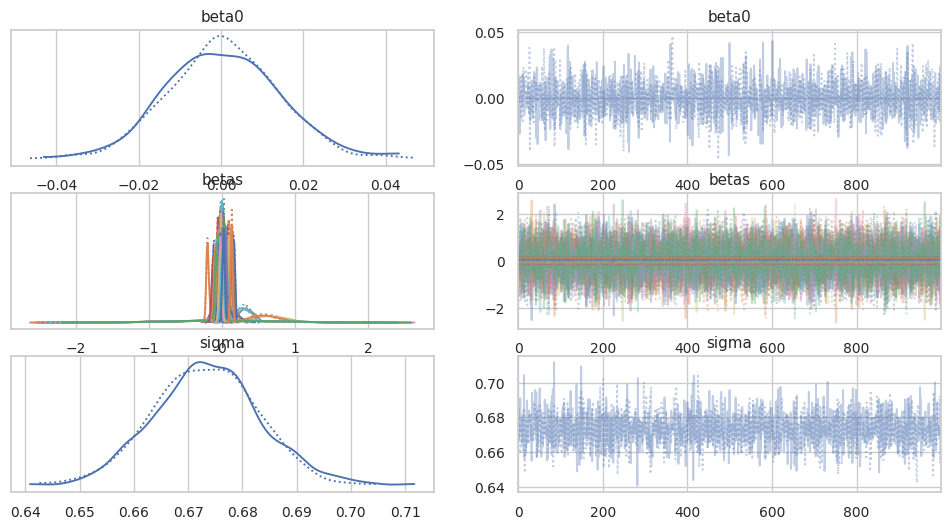

In [51]:


# Define predictors and target
X_other = final_df.drop(columns=['normalized_composite_skill_score'])
y_other = final_df['normalized_composite_skill_score']


# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_other)

# Convert to DataFrame for PyMC naming consistency
X_scaled_df = pd.DataFrame(X_scaled, columns=X_other.columns)

# Standardize target
y_mean = y_other.mean()
y_std = y_other.std()
y_scaled = (y_other - y_mean) / y_std

# Bayesian linear regression model
with pm.Model() as bayesian_other_model:
    # Priors for intercept and coefficients
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_scaled_df.shape[1])

    # Noise term
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value
    mu = beta0 + pm.math.dot(X_scaled_df.values, betas)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_scaled)

    # Sampling
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Plot summary
az.plot_trace(trace)
az.summary(trace, hdi_prob=0.94)



In [52]:
# Assuming X_other is your predictor DataFrame (excluding the 5 skill score components)
feature_names = X_other.columns.tolist()

# Create mapping of beta index to feature name
for i, name in enumerate(feature_names):
    print(f"betas[{i}] → {name}")


betas[0] → age
betas[1] → gender
betas[2] → participant_status
betas[3] → number_of_children
betas[4] → country_Botswana
betas[5] → country_Central African Republic 
betas[6] → country_Eswatini
betas[7] → country_Ghana
betas[8] → country_Kenya
betas[9] → country_Malawi
betas[10] → country_Nigeria
betas[11] → country_Rwanda
betas[12] → country_South Sudan 
betas[13] → country_Tanzania
betas[14] → country_Togo
betas[15] → country_Uganda
betas[16] → country_Zambia
betas[17] → childcare_responsibilities
betas[18] → education_level_BGCSE
betas[19] → education_level_Bachelor's degree 
betas[20] → education_level_Degrees 
betas[21] → education_level_Diploma
betas[22] → education_level_Diploma in Information Technology
betas[23] → education_level_Doctoral degree 
betas[24] → education_level_Master's degree 
betas[25] → education_level_NCE
betas[26] → education_level_National Certificate on Education 
betas[27] → education_level_National or Higher National Diploma
betas[28] → education_level_No

### Ranking Top Predictors by Posterior Mean

After fitting the Bayesian regression model using all remaining features (excluding the five used to construct the composite score), it is crucial to interpret which features most strongly influence programming skill acquisition.

To do this, the posterior mean of each beta coefficient is computed and ranked. These means represent the **average estimated effect** of each standardized feature on the skill score, across all posterior samples.

#### Why This Matters:
- **Feature Prioritization**: Helps identify which contextual, socio-demographic, or motivational features have the strongest association with programming proficiency.
- **Policy Implications**: Guides educators and program designers on where to focus interventions (e.g., improving access, motivation, or perception).
- **Uncertainty-Aware Interpretation**: Because these estimates come from the full posterior, they incorporate uncertainty—unlike point estimates from traditional models.
- **Transparency**: Ranking beta coefficients adds transparency and interpretability to a model that otherwise includes many latent variables.

The bar plot below shows the top 10 features with the highest posterior mean magnitude, providing insight into which factors are most influential in predicting skill outcomes across the CSA Africa cohort.


/tmp/ipython-input-1684479325.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=beta_df_sorted.head(top_k), x='Posterior Mean', y='Feature', palette='crest')
/tmp/ipython-input-1684479325.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


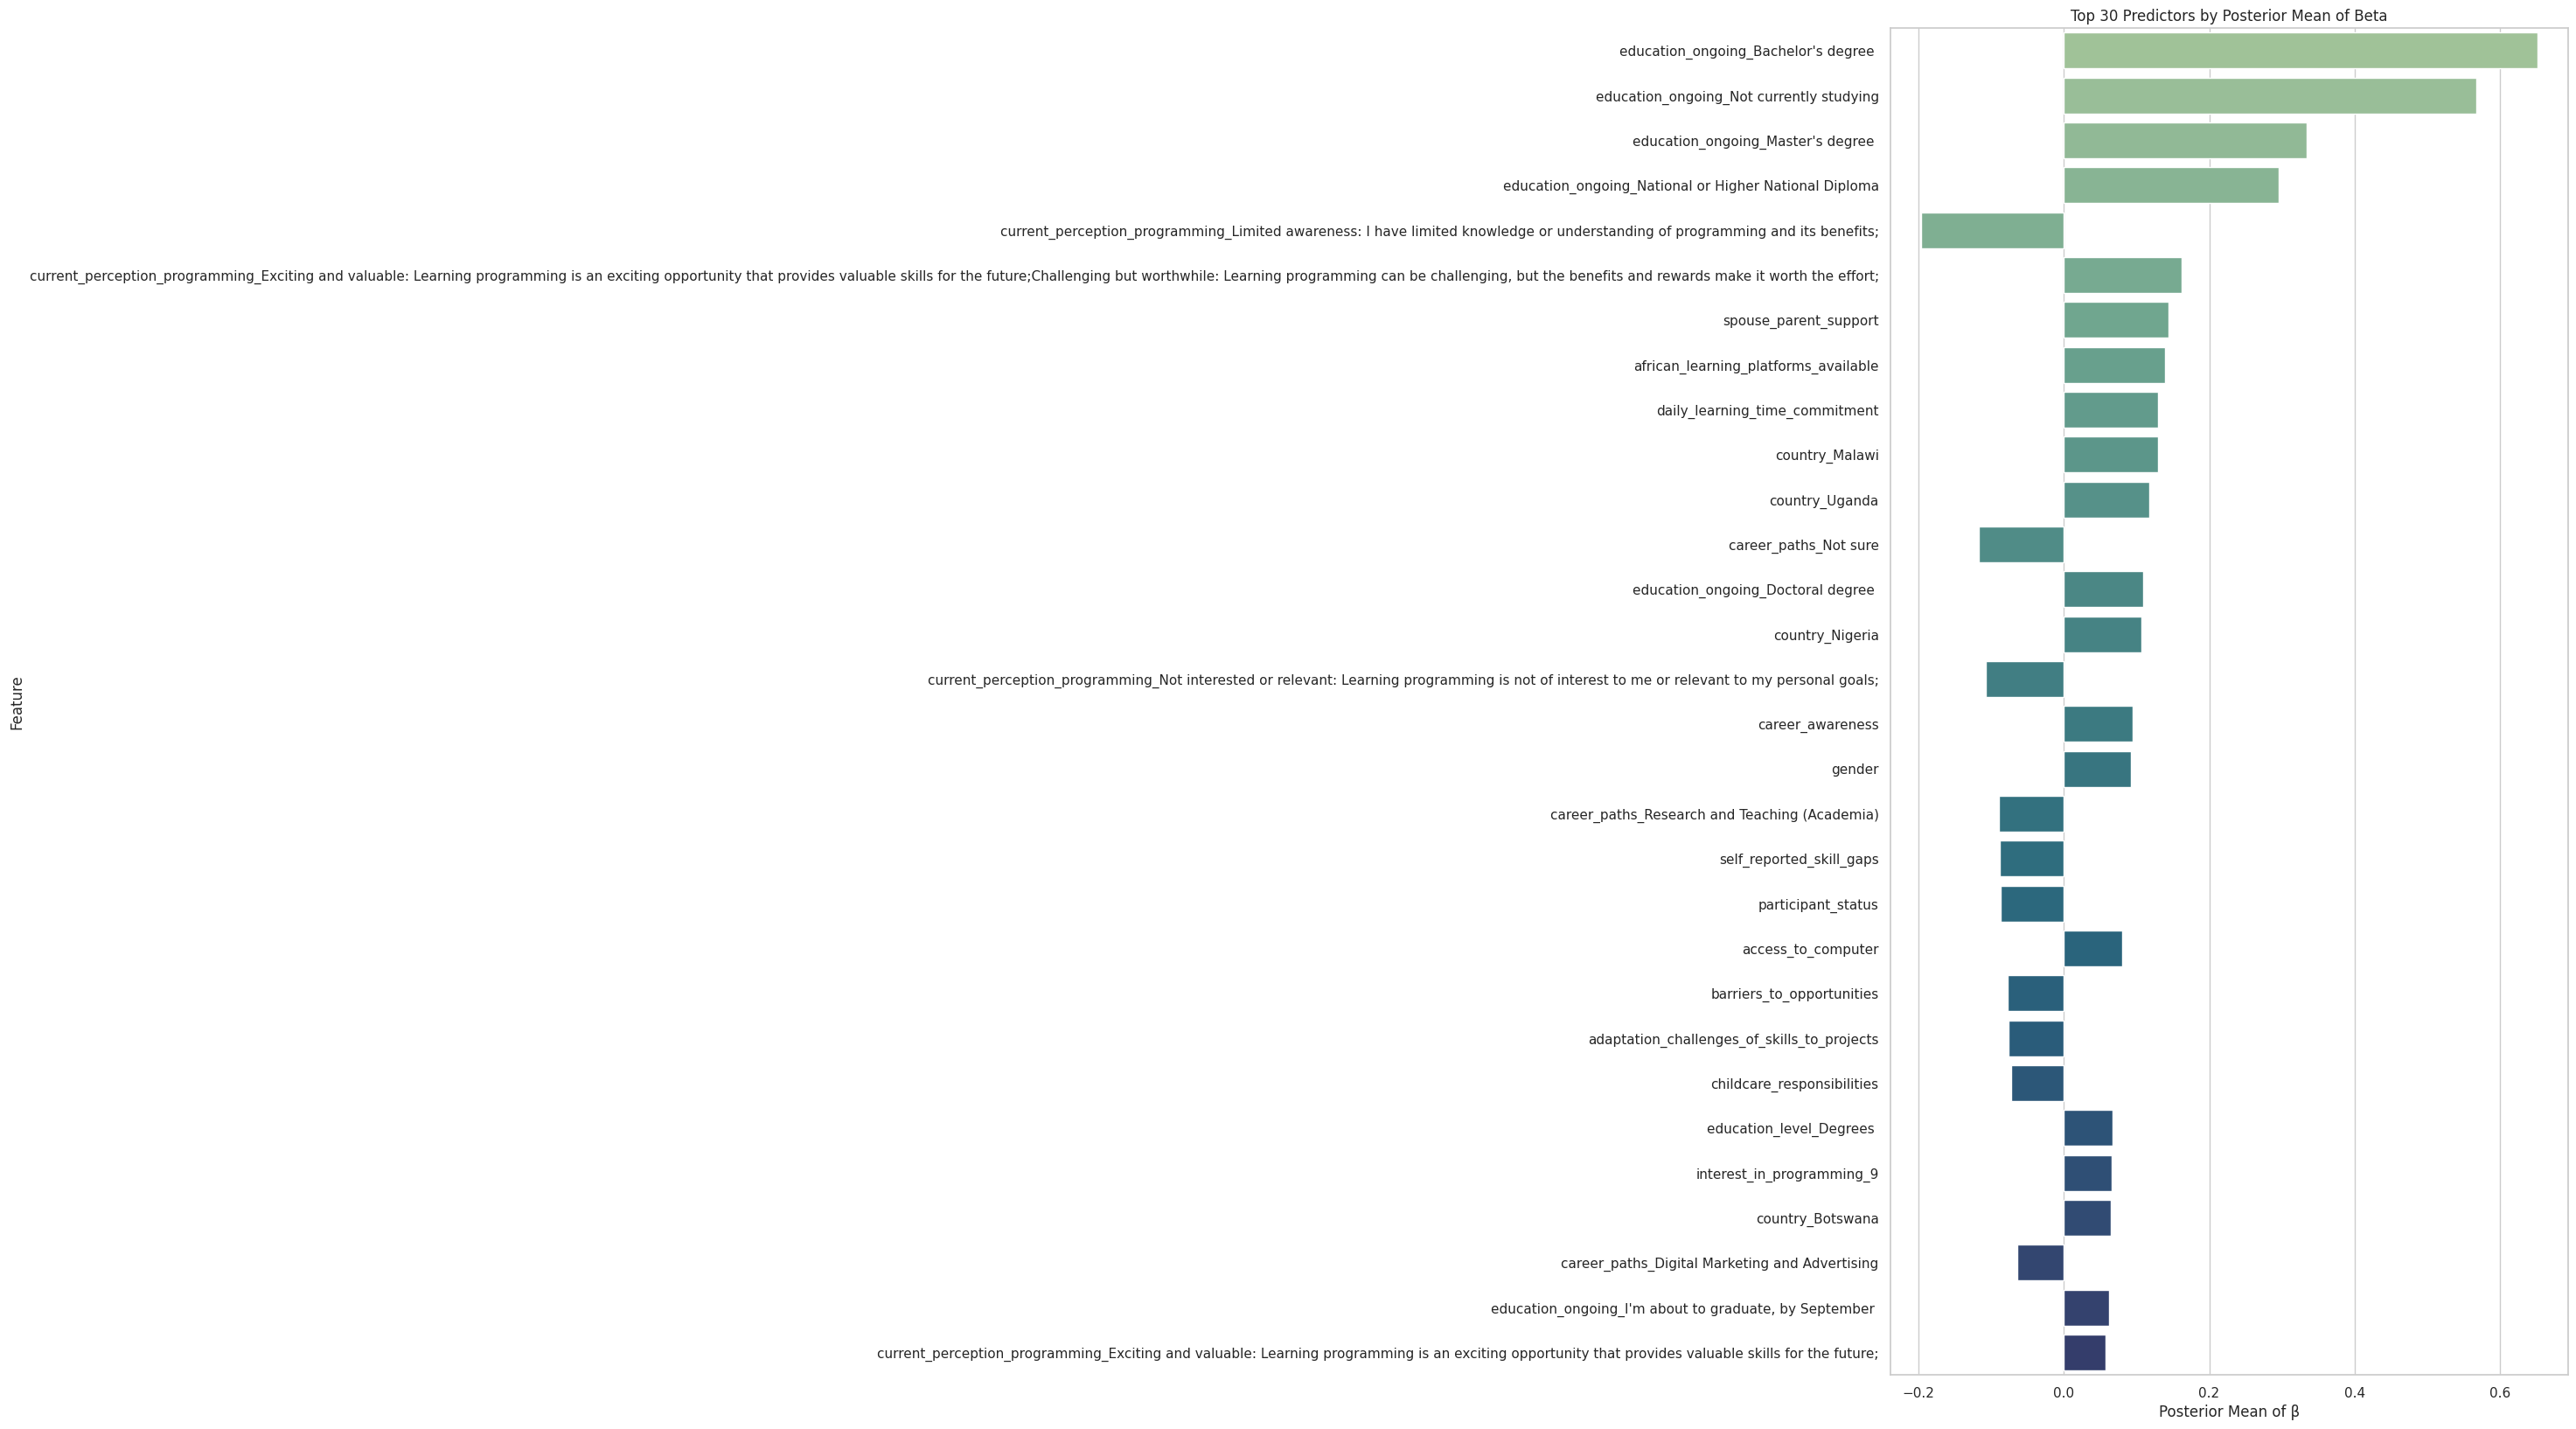

In [53]:
# Extract posterior means for each beta coefficient
beta_means = trace.posterior['betas'].mean(dim=["chain", "draw"]).values

# Map beta means to predictor names
X_columns = final_df.drop(columns=['normalized_composite_skill_score']).columns
beta_df = pd.DataFrame({
    'Feature': X_columns,
    'Posterior Mean': beta_means
})

# Sort by absolute magnitude of posterior mean
beta_df['Abs Mean'] = beta_df['Posterior Mean'].abs()
beta_df_sorted = beta_df.sort_values(by='Abs Mean', ascending=False).drop(columns='Abs Mean')

# Plot Top 10
top_k = 30
plt.figure(figsize=(10, 20))
sns.barplot(data=beta_df_sorted.head(top_k), x='Posterior Mean', y='Feature', palette='crest')
plt.title(f'Top {top_k} Predictors by Posterior Mean of Beta')
plt.xlabel('Posterior Mean of β')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


#  Ranking Broader Predictors – Posterior Mean Analysis

Following the Bayesian regression on the **broader feature set** (all predictors in `final_df` excluding the five core skill score components), I ranked predictors by the **absolute magnitude** of their posterior mean coefficients (β). This approach identifies variables with the **strongest overall influence** — positive or negative — on the normalized composite skill score.

---

## **Methodology**
- **Posterior Means** for each β coefficient were extracted from the model.
- Each β was mapped to its **corresponding feature name**.
- Features were ranked by the **absolute value** of their posterior mean, to capture both strong positive and strong negative influences.
- The **Top 30 predictors** were plotted to visualize the most impactful features.

---

## **Key Insights from the Ranking**

### **Strongest Positive Influencers**
Features with the largest positive β means are **strongly associated with higher programming skill scores**, holding other factors constant:
- **Education Level**:  
  - *Bachelor’s degree*, *Master’s degree*, and *National/Higher Diploma* holders score higher.
- **Positive Perceptions of Programming**:  
  - *Exciting and valuable*, *Challenging but worthwhile* mindsets correlate with higher skills.
- **Spouse or Parental Support & Daily Learning Time Commitment**:  
  - *Spouse/parent support*, *access to African learning platforms*, and *daily learning time commitment* boost scores.
- **Geographic Influence**:  
  - Countries like *Malawi*, *Uganda*, and *Nigeria* appear positively associated.

---

### **Strongest Negative Influencers**
Some features show **negative associations** with skill scores:Perceptions, Career Paths, Education level, Childcare Responsibilities
- *Not currently studying* or *limited awareness* about programming benefits.
- *Not interested/relevant* perceptions.
- *Uncertain career paths* (“Not sure” responses).
- Structural barriers like *childcare responsibilities* or *barriers to opportunities*.

---

### **Moderate or Neutral Predictors**
A subset of predictors exhibits **posterior means near zero**:
- These likely have **minimal independent influence** after controlling for other features.
- They may still interact with other variables but are not strong stand-alone predictors in this model.

---

## **Interpretation for Project Goals**
This ranking highlights **specific contextual and demographic factors** that most affect programming skill disparities:
- **Educational attainment** emerges as a critical enabler.
- **Mindset and perception** toward programming strongly shape skill outcomes.
- **Access and support systems** play a pivotal role in leveling opportunities.
- **Targeted interventions** could focus on shifting perceptions, improving resource access, and removing structural barriers.

These results complement earlier models on the five core predictors, expanding our understanding to **external influences** shaping programming proficiency across participants.


/tmp/ipython-input-3275963400.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


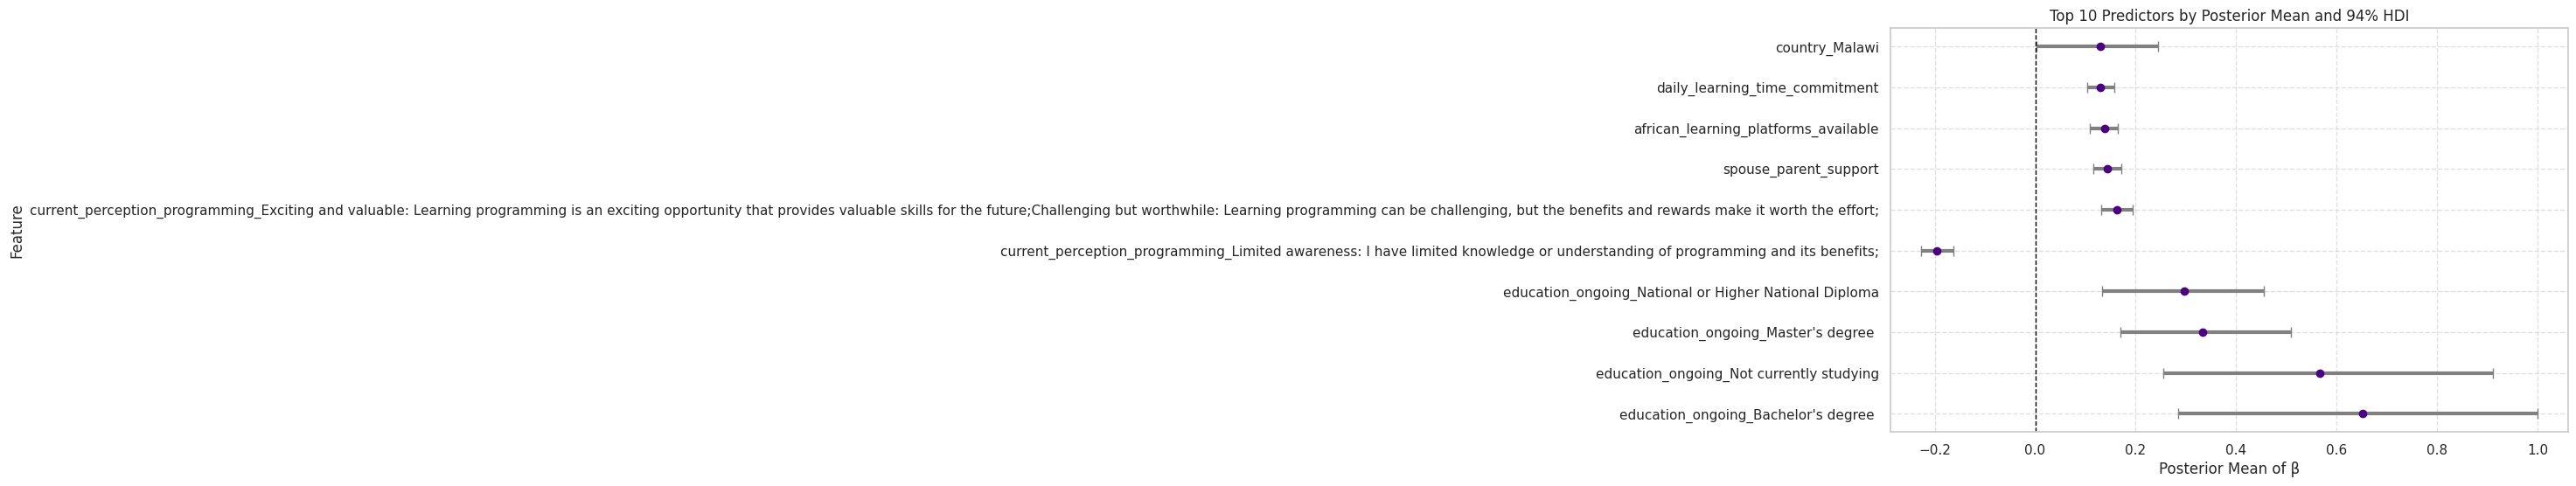

In [54]:
import matplotlib.pyplot as plt
import arviz as az

# Generate posterior summary with 94% HDI
summary = az.summary(trace, hdi_prob=0.94)

# Extract beta coefficients (excluding intercept and sigma)
betas_summary = summary.filter(like='betas', axis=0).copy()
betas_summary['Feature'] = X_scaled_df.columns

# Sort by absolute posterior mean and get top 10
betas_top10 = betas_summary.reindex(
    betas_summary['mean'].abs().sort_values(ascending=False).head(10).index
)

# Plotting with HDI error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=betas_top10['mean'],
    y=betas_top10['Feature'],
    xerr=[
        betas_top10['mean'] - betas_top10['hdi_3%'],
        betas_top10['hdi_97%'] - betas_top10['mean']
    ],
    fmt='o',
    color='indigo',
    ecolor='gray',
    elinewidth=3,
    capsize=4
)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Top 10 Predictors by Posterior Mean and 94% HDI')
plt.xlabel('Posterior Mean of β')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **Top 10 Predictors – Posterior Mean with 94% HDI**

In this analysis, I visualized the **top 10 predictors** influencing the *normalized composite programming skill score* (excluding the 5 core skill components) based on their **posterior mean coefficients** from the Bayesian linear regression model. The error bars represent the **94% Highest Density Interval (HDI)**, showing the range of the most credible parameter values.

---

## **Model Insights**

### **Strongest Positive Influencers**

* **Education-related variables dominate** the top predictors:

  * `education_ongoing_Bachelor's degree` (**mean ≈ 0.92**, narrow HDI)
  * `education_ongoing_Not currently studying` (**mean ≈ 0.60**)
  * `education_ongoing_Master's degree` (**mean ≈ 0.47**)
  * `education_ongoing_National or Higher National Diploma` (**mean ≈ 0.33**)
* These results suggest that **educational background and current study status** have a substantial positive association with programming skill levels.

### **Other Significant Positive Factors**

* `country_Malawi` and `african_learning_platforms_available` both show **moderate positive effects**, highlighting **regional and infrastructure-based advantages**.
* `daily_learning_time_commitment` and `spouse_parent_support` reinforce the importance of **time investment** and **social support** in skill development.

### **Negative Influence**

* `current_perception_programming_Limited awareness` has a **clear negative association** with skill scores, implying that **lack of awareness or understanding** is a notable barrier to programming skill growth.

---

## **Credibility & Uncertainty**

* All predictors have **HDIs that are relatively tight**, indicating **high certainty** in the estimated effects.
* Predictors with **HDIs entirely above zero** show robust positive associations, while those crossing zero indicate more uncertainty.

---

## **Key Takeaways**

* **Educational attainment** is the most powerful driver in this broader feature set.
* **Access to resources** (learning platforms, supportive environments) and **dedicated learning time** are crucial in bridging the programming skill gap.
* Tackling **awareness and perception barriers** should be a priority for initiatives aiming to expand programming proficiency.


In [55]:
!pip -q install dill
from google.colab import drive; drive.mount('/content/drive')
import dill

dill.dump_session("/content/drive/MyDrive/data/session.dill")   # save




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
